In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt


In [2]:
"""
def display_transposedimages_from_hdf5(file_path, num_images_to_display=12):
    with h5py.File(file_path, 'r') as f:
        # Access the dataset
        images_dataset = f['images']
        num_images, height, width, num_channels = images_dataset.shape
        print(images_dataset.shape)
        
        print(f"Dataset contains {num_images} images with {num_channels} channels each, of size {height}x{width}.")

        # Display the first few images
        
        plt.figure(figsize=(20, 20))
        for i in range(min(num_images_to_display, num_images)):
            for j in range(images_dataset.shape[-1]):  # Loop over channels in NHWC format
                img = images_dataset[i, :, :, j]
                plt.subplot(num_images_to_display, images_dataset.shape[-1], i * images_dataset.shape[-1] + j + 1)
                plt.imshow(img, cmap='inferno')
                plt.title(f'Image {i}, Channel {j}')
                plt.axis('off')
            
        plt.show()
        return images_dataset
 
output_file_path = 'fluor_images_transposed.h5'
images_dataset_transposed = display_transposedimages_from_hdf5(output_file_path)
"""

'\ndef display_transposedimages_from_hdf5(file_path, num_images_to_display=12):\n    with h5py.File(file_path, \'r\') as f:\n        # Access the dataset\n        images_dataset = f[\'images\']\n        num_images, height, width, num_channels = images_dataset.shape\n        print(images_dataset.shape)\n        \n        print(f"Dataset contains {num_images} images with {num_channels} channels each, of size {height}x{width}.")\n\n        # Display the first few images\n        \n        plt.figure(figsize=(20, 20))\n        for i in range(min(num_images_to_display, num_images)):\n            for j in range(images_dataset.shape[-1]):  # Loop over channels in NHWC format\n                img = images_dataset[i, :, :, j]\n                plt.subplot(num_images_to_display, images_dataset.shape[-1], i * images_dataset.shape[-1] + j + 1)\n                plt.imshow(img, cmap=\'inferno\')\n                plt.title(f\'Image {i}, Channel {j}\')\n                plt.axis(\'off\')\n            \n

In [3]:
from keras import backend as K
K.set_image_data_format('channels_last')

2024-08-07 03:10:22.806893: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-07 03:10:22.973504: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 03:10:24.303986: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-08-07 03:10:24.304071: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

**PatchGAN Discriminator**

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv3D, LeakyReLU, Activation, Concatenate, BatchNormalization, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal

def define_discriminator(input_shape_2d, output_shape_3d):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    
    # source image input (2D brightfield)
    in_src_image = Input(shape=input_shape_2d)
    
    # target image input (3D fluorescence)
    in_target_image = Input(shape=output_shape_3d)
    
    # Expand dimensions of source image to match target image
    #expanded_src = Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                          #output_shape=lambda input_shape: input_shape + (1,))(in_src_image)

    
    # Expand dimensions of source image to match target image
    expanded_src = Lambda(lambda x: tf.expand_dims(x, axis=-1),
                          output_shape=lambda input_shape: input_shape + (1,))(in_src_image)

    expanded_src = Lambda(lambda x: tf.tile(x, [1, 1, 1, 1, output_shape_3d[-1]]),
                          output_shape=lambda input_shape: input_shape[:-1] + (output_shape_3d[-1],))(expanded_src)

    expanded_src = Reshape((input_shape_2d[0], input_shape_2d[1], output_shape_3d[-1]))(expanded_src)

    # concatenate images channel-wise
    merged = Concatenate(axis=-1)([expanded_src, in_target_image])
    
    # Reshape merged tensor to 5D for Conv3D
    merged = Reshape((128, 128, output_shape_3d[-1] * 2, 1))(merged)
    
    # C64
    d = Conv3D(64, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    
    # C128
    d = Conv3D(128, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # C256
    d = Conv3D(256, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # C512
    d = Conv3D(512, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # second last output layer
    d = Conv3D(512, (4,4,4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # patch output
    d = Conv3D(1, (4,4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    
    # define model
    model = Model([in_src_image, in_target_image], patch_out)
    
    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    
    return model

# define image shapes
input_shape_2d = (128, 128, 1)  # 2D brightfield image
output_shape_3d = (128, 128, 6)  # 3D fluorescence image with 6 channels

# create the model
model = define_discriminator(input_shape_2d, output_shape_3d)

# summarize the model
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 1,  0           ['input_1[0][0]']                
                                 1)                                                               
                                                                                                  
 lambda_1 (Lambda)              (None, 128, 128, 1,  0           ['lambda[0][0]']                 
                                 6)                                                           

2024-08-07 03:10:26.332853: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-07 03:10:26.353974: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-07 03:10:26.354586: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-07 03:10:26.355470: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operati

In [5]:
from tensorflow.keras.utils import plot_model
import tensorflow as tf

# After defining your model
tf.keras.utils.plot_model(
    model,
    to_file="discriminator_model_plot.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [6]:
from tensorflow.keras.losses import Loss
from tensorflow.image import ssim
import tensorflow as tf

class SSIMLoss(Loss):
    def __init__(self, max_val=1.0, **kwargs):
        super().__init__(**kwargs)
        self.max_val = max_val

    def call(self, y_true, y_pred):
        return 1 - tf.reduce_mean(ssim(y_true, y_pred, max_val=self.max_val))

    def get_config(self):
        config = super().get_config()
        config.update({"max_val": self.max_val})
        return config

# Register the custom object
tf.keras.utils.get_custom_objects()['SSIMLoss'] = SSIMLoss



# U-Net Generator

In [7]:
# example of defining a u-net encoder-decoder generator model
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
#from keras.utils.vis_utils import plot_model

# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init, data_format='channels_last')(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add upsampling layer
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init, data_format='channels_last')(layer_in)
    # add batch normalization
    g = BatchNormalization()(g, training=True)
    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # relu activation
    g = Activation('relu')(g)
    return g

# define the standalone generator model
def define_generator(image_shape=(128, 128, 1), output_channels = 6):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    # encoder model: C64-C128-C256-C512-C512-C512-C512-C512
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    #e7 = define_encoder_block(e6, 512)
    # bottleneck, no batch norm and relu
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init, data_format='channels_last')(e6)
    b = Activation('relu')(b)
    # decoder model: CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128
    d1 = decoder_block(b, e6, 512)
    d2 = decoder_block(d1, e5, 512)
    d3 = decoder_block(d2, e4, 512)
    #d4 = decoder_block(d3, e4, 512, dropout=False)
    d4 = decoder_block(d3, e3, 256, dropout=False)
    d5 = decoder_block(d4, e2, 128, dropout=False)
    d6 = decoder_block(d5, e1, 64, dropout=False)
    # output
    out_image = Conv2DTranspose(output_channels, (4,4), strides=(2,2), padding='same', kernel_initializer=init, data_format='channels_last')(d6)
    #out_image = Activation('tanh')(g)
    # define model
    model = Model(in_image, out_image)
    ssim_loss = SSIMLoss(max_val=1.0)
    model.compile(optimizer='adam', loss=ssim_loss)
    return model

# define image shape
image_shape = (128, 128, 1)

output_channels = 6
# create the model
model = define_generator(image_shape, output_channels)
# summarize the model
model.summary()
# plot the model
#plot_model(model, to_file='generator_model_plot.png', show_shapes=True, show_layer_names=True)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   1088        ['input_3[0][0]']                
                                                                                                  
 leaky_re_lu_5 (LeakyReLU)      (None, 64, 64, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 128)  131200      ['leaky_re_lu_5[0][0]']    

In [8]:
from tensorflow.keras.utils import plot_model
import tensorflow as tf

# After defining your model
tf.keras.utils.plot_model(
    model,
    to_file="generator_model_plot.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [9]:

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True
    # define the source image
    in_src = Input(shape=image_shape)
    # connect the source image to the generator input
    gen_out = g_model(in_src)
    # connect the source input and generator output to the discriminator input
    dis_out = d_model([in_src, gen_out])
    # src image as input, generated image and classification output
    model = Model(in_src, [dis_out, gen_out])
    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    ssim_loss = SSIMLoss(max_val=1.0)
    model.compile(loss = ['binary_crossentropy', ssim_loss], optimizer=opt, loss_weights = [1,100])
    return model

In [10]:
custom_objects = {'SSIMLoss': SSIMLoss}

In [11]:
# define image shape
image_shape = (128, 128, 1)
output_shape_3d = (128, 128, 6)
# define the models
d_model = define_discriminator(image_shape, output_shape_3d)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# summarize the model
gan_model.summary()
# plot the model
plot_model(gan_model, to_file='gan_model_plot.png', show_shapes=True, show_layer_names=True)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 model_3 (Functional)           (None, 128, 128, 6)  41845382    ['input_7[0][0]']                
                                                                                                  
 model_2 (Functional)           (None, 8, 8, 1, 1)   27831233    ['input_7[0][0]',                
                                                                  'model_3[0][0]']                
                                                                                            

# Updating the model weights

In [12]:

import numpy as np
from numpy.random import randint
from numpy import ones
from numpy import zeros
import tensorflow as tf

def split_dataset(dataset):
    # Check the dimensions of the dataset
    if dataset.shape != (2000, 128, 128, 7):
        raise ValueError('Dataset dimensions do not match the expected shape (2000, 128, 128, 7)')
    
    
    # Extract the brightfield images (channel 0)
    brightfield_images = dataset[:, :, :, 0]

    # Extract the fluorescence images (channels 1-6)
    fluorescence_images = dataset[:, :, :, 1:7]

    # Verify the shapes
    print("Brightfield images shape:", brightfield_images.shape)  # Should be (16338, 128, 128)
    print("Fluorescence images shape:", fluorescence_images.shape)  # Should be (16338, 128, 128, 6)

    return brightfield_images, fluorescence_images



In [13]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = split_dataset(dataset)
    print('trainA shape:', trainA.shape)
    print('trainB shape:', trainB.shape)
    # choose random instances
    ix = randint(0, trainA.shape[0], n_samples)
    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
    # generate 'real' class labels (1)
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

In [14]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape): 
    # Ensure samples are in channels_last format

    # generate fake instance
    X = g_model.predict(samples)
    # create 'fake' class labels (0)
    y = np.zeros((len(X),patch_shape, patch_shape, 1))
    return X, y

In [15]:
"""
def check_dataset_format(file_path):
    with h5py.File(file_path, 'r') as f:
        # Access the dataset
        images_dataset = f['images']
        num_images, height, width, num_channels = images_dataset.shape
        print(f"Dataset shape: {images_dataset.shape}")
        print(f"Dataset contains {num_images} images with {num_channels} channels each, of size {height}x{width}.")
        
        # Verify the datatype
        datatype = images_dataset.dtype
        print(f"Image datatype: {datatype}")

        # Check if the dataset follows NHWC format
        if len(images_dataset.shape) == 4 and images_dataset.shape[1] == height and images_dataset.shape[2] == width and images_dataset.shape[3] == num_channels:
            print("Dataset follows NHWC format.")
        else:
            print("Dataset does not follow NHWC format.")
        
        return images_dataset

# Usage
file_path = 'transposed_normalized_images.h5'
images_dataset = check_dataset_format(file_path)

"""

'\ndef check_dataset_format(file_path):\n    with h5py.File(file_path, \'r\') as f:\n        # Access the dataset\n        images_dataset = f[\'images\']\n        num_images, height, width, num_channels = images_dataset.shape\n        print(f"Dataset shape: {images_dataset.shape}")\n        print(f"Dataset contains {num_images} images with {num_channels} channels each, of size {height}x{width}.")\n        \n        # Verify the datatype\n        datatype = images_dataset.dtype\n        print(f"Image datatype: {datatype}")\n\n        # Check if the dataset follows NHWC format\n        if len(images_dataset.shape) == 4 and images_dataset.shape[1] == height and images_dataset.shape[2] == width and images_dataset.shape[3] == num_channels:\n            print("Dataset follows NHWC format.")\n        else:\n            print("Dataset does not follow NHWC format.")\n        \n        return images_dataset\n\n# Usage\nfile_path = \'transposed_normalized_images.h5\'\nimages_dataset = check_datas

In [16]:
n_batch = 1000
n_patch = 8
#print(images_dataset.shape)
#file_path = 'transposed_normalized_images.h5'


#data = np.load('fluor_images_transposed_asnumpy.npz')


#print(data.files)
#data = data['array']

"""
# Open the file and keep it open
f = h5py.File(file_path, 'r')
images_dataset = f['images']
import numpy as np
"""

# Number of images to extract
#num_images_to_extract = 2000

# Randomly select 2000 indices from the dataset
#indices = np.arange(2000)

# Extract the selected images
#extracted_images = data[:num_images_to_extract]
#images_dataset = extracted_images

# Check the shape of the extracted images
#print("Extracted images shape:", extracted_images.shape)
#print("Extracted images shape:", images_dataset.shape)

#images_dataset = normalized_dataset(images_dataset)


# select a batch of real samples


"\n# Open the file and keep it open\nf = h5py.File(file_path, 'r')\nimages_dataset = f['images']\nimport numpy as np\n"

In [17]:
def brightfield_images(minimum_value, maximum_value, images_dataset):
    for i in range(images_dataset.shape[0]):
        img = images_dataset[i, :, :, 0]
        if(np.min(img) <minimum_value):
            minimum_value = np.min(img)
        if(np.max(img) > maximum_value):
            maximum_value = np.max(img)

    return [minimum_value, maximum_value] 

def channel1_images(minimum_value, maximum_value, images_dataset):
    for i in range(images_dataset.shape[0]):
        img = images_dataset[i, :, :, 1]
        if(np.min(img) <minimum_value):
            minimum_value = np.min(img)
        if(np.max(img) > maximum_value):
            maximum_value = np.max(img)
    return [minimum_value, maximum_value]


def channel2_images(minimum_value, maximum_value, images_dataset):
    for i in range(images_dataset.shape[0]):
        img = images_dataset[i, :, :, 2]
        if(np.min(img) < minimum_value):
            minimum_value = np.min(img)
        if(np.max(img) > maximum_value):
            maximum_value = np.max(img)

    return [minimum_value, maximum_value]

def channel3_images(minimum_value, maximum_value, images_dataset):
    for i in range(images_dataset.shape[0]):
        img = images_dataset[i, :, :, 3]
        if(np.min(img) < minimum_value):
            minimum_value = np.min(img)
        if(np.max(img) > maximum_value):
            maximum_value = np.max(img)
    return [minimum_value, maximum_value]

def channel4_images(minimum_value, maximum_value, images_dataset):
    for i in range(images_dataset.shape[0]):
        img = images_dataset[i, :, :, 4]
        if(np.min(img) < minimum_value):
            minimum_value = np.min(img)
        if(np.max(img) > maximum_value):
            maximum_value = np.max(img)
    return [minimum_value, maximum_value]

def channel5_images(minimum_value, maximum_value, images_dataset):
    for i in range(images_dataset.shape[0]):
        img = images_dataset[i, :, :, 5]
        if(np.min(img) < minimum_value):
            minimum_value = np.min(img)
        if(np.max(img) > maximum_value):
            maximum_value = np.max(img)
    return [minimum_value, maximum_value]

def channel6_images(minimum_value, maximum_value, images_dataset):
    for i in range(images_dataset.shape[0]):
        img = images_dataset[i, :, :, 6]
        if(np.min(img) < minimum_value):
            minimum_value = np.min(img)
        if(np.max(img) > maximum_value):
            maximum_value = np.max(img)
    return [minimum_value, maximum_value]

def normalization_process(image, min_val, max_val):
    image = (((image.astype(np.float32) - min_val) / (max_val - min_val)) * 65535).astype(np.float32)
    image = (image.astype(np.float32)/ 65535).astype(np.float32)
    return image

In [18]:
def normalization_of_images(images_dataset):
    
    minimum_value_bf =  np.min(images_dataset[:, :, :, 0])  
    maximum_value_bf = np.max(images_dataset[:, :, :, 0])
    
    minimum_value_1 =  np.min(images_dataset[:, :, :, 1])  
    maximum_value_1 = np.max(images_dataset[:, :, :, 1])
    
    minimum_value_2 =  np.min(images_dataset[:, :, :, 2])  
    maximum_value_2 = np.max(images_dataset[:, :, :, 2])
    
    minimum_value_3 =  np.min(images_dataset[:, :, :, 3])  
    maximum_value_3 = np.max(images_dataset[:, :, :, 3])
    
    minimum_value_4 =  np.min(images_dataset[:, :, :, 4])  
    maximum_value_4 = np.max(images_dataset[:, :, :, 4])
    
    minimum_value_5 =  np.min(images_dataset[:, :, :, 5])  
    maximum_value_5 = np.max(images_dataset[:, :, :, 5])

    minimum_value_6 =  np.min(images_dataset[:, :, :, 6])  
    maximum_value_6 = np.max(images_dataset[:, :, :, 6])
    
    
    minimum_value_bf, maximum_value_bf =  brightfield_images(minimum_value_bf, maximum_value_bf, images_dataset) 
    minimum_value_1, maximum_value_1 =  channel1_images(minimum_value_1, maximum_value_1, images_dataset) 
    minimum_value_2, maximum_value_2 =  channel2_images(minimum_value_2, maximum_value_2, images_dataset) 
    minimum_value_3, maximum_value_3 =  channel3_images(minimum_value_3, maximum_value_3, images_dataset) 
    minimum_value_4, maximum_value_4 =  channel4_images(minimum_value_4, maximum_value_4, images_dataset) 
    minimum_value_5, maximum_value_5 =  channel5_images(minimum_value_5, maximum_value_5, images_dataset) 
    minimum_value_6, maximum_value_6 =  channel6_images(minimum_value_6, maximum_value_6, images_dataset) 
    
   
    
    
    for i in range(images_dataset.shape[0]):
        for j in range(images_dataset.shape[-1]):
            if(j==0):
                image = images_dataset[i, :, :, j]
                temp_image = normalization_process(image, minimum_value_bf, maximum_value_bf)
                images_dataset[i, :, :, j] = temp_image
                
            if(j==1):
                image = images_dataset[i, :, :, j]
                temp_image = normalization_process(image, minimum_value_1, maximum_value_1)
                images_dataset[i, :, :, j] = temp_image
                
            if(j==2):
                image = images_dataset[i, :, :, j]
                temp_image = normalization_process(image, minimum_value_1, maximum_value_2)
                images_dataset[i, :, :, j] = temp_image
            
            if(j==3):
                image = images_dataset[i, :, :, j]
                temp_image = normalization_process(image, minimum_value_1, maximum_value_3)
                images_dataset[i, :, :, j] = temp_image
                
            if(j==4):
                image = images_dataset[i, :, :, j]
                temp_image = normalization_process(image, minimum_value_1, maximum_value_4)
                images_dataset[i, :, :, j] = temp_image
                
            if(j==5):
                image = images_dataset[i, :, :, j]
                temp_image = normalization_process(image, minimum_value_1, maximum_value_5)
                images_dataset[i, :, :, j] = temp_image
                
            if(j==6):
                image = images_dataset[i, :, :, j]
                temp_image = normalization_process(image, minimum_value_1, maximum_value_6)
                images_dataset[i, :, :, j] = temp_image
            
        

    
    
                
    print("minimum value in channel of brightfield images = ", minimum_value_bf)
    print("maximum value in channel of brightfield images = ", maximum_value_bf)
    print() 
    
    print("minimum value in channel 1 of images = ", minimum_value_1)
    print("maximum value in channel 1 of images = ", maximum_value_1)
    print() 
    
    print("minimum value in channel 2 of images = ", minimum_value_2)
    print("maximum value in channel 2 of images = ", maximum_value_2)
    print() 
    
    print("minimum value in channel 3 of images = ", minimum_value_3)
    print("maximum value in channel 3 of images = ", maximum_value_3)
    print() 
    
    print("minimum value in channel 4 of images = ", minimum_value_4)
    print("maximum value in channel 4 of images = ", maximum_value_4)
    print() 
    
    print("minimum value in channel 5 of images = ", minimum_value_5)
    print("maximum value in channel 5 of images = ", maximum_value_5)
    print() 
    
    print("minimum value in channel 6 of images = ", minimum_value_6)
    print("maximum value in channel 6 of images = ", maximum_value_6)
    print()
    
    print("shape of normalized images dataset = ", images_dataset.shape)
    #print("maximum value in channel 6 of images = ", maximum_value_6)
    print()
    
    return images_dataset
    

In [19]:
#images_dataset = normalization_of_images(images_dataset)


In [20]:
#print(images_dataset.dtype)

In [21]:
def min_and_max_images(images_dataset):    
    minimum_value_bf =  np.min(images_dataset[:, :, :, 0])  
    maximum_value_bf = np.max(images_dataset[:, :, :, 0])

    minimum_value_1 =  np.min(images_dataset[:, :, :, 1])  
    maximum_value_1 = np.max(images_dataset[:, :, :, 1])

    minimum_value_2 =  np.min(images_dataset[:, :, :, 2])  
    maximum_value_2 = np.max(images_dataset[:, :, :, 2])

    minimum_value_3 =  np.min(images_dataset[:, :, :, 3])  
    maximum_value_3 = np.max(images_dataset[:, :, :, 3])

    minimum_value_4 =  np.min(images_dataset[:, :, :, 4])  
    maximum_value_4 = np.max(images_dataset[:, :, :, 4])

    minimum_value_5 =  np.min(images_dataset[:, :, :, 5])  
    maximum_value_5 = np.max(images_dataset[:, :, :, 5])

    minimum_value_6 =  np.min(images_dataset[:, :, :, 6])  
    maximum_value_6 = np.max(images_dataset[:, :, :, 6])
    
                    
    print("minimum value in channel of brightfield images = ", minimum_value_bf)
    print("maximum value in channel of brightfield images = ", maximum_value_bf)
    print() 
    
    print("minimum value in channel 1 of images = ", minimum_value_1)
    print("maximum value in channel 1 of images = ", maximum_value_1)
    print() 
    
    print("minimum value in channel 2 of images = ", minimum_value_2)
    print("maximum value in channel 2 of images = ", maximum_value_2)
    print() 
    
    print("minimum value in channel 3 of images = ", minimum_value_3)
    print("maximum value in channel 3 of images = ", maximum_value_3)
    print() 
    
    print("minimum value in channel 4 of images = ", minimum_value_4)
    print("maximum value in channel 4 of images = ", maximum_value_4)
    print() 
    
    print("minimum value in channel 5 of images = ", minimum_value_5)
    print("maximum value in channel 5 of images = ", maximum_value_5)
    print() 
    
    print("minimum value in channel 6 of images = ", minimum_value_6)
    print("maximum value in channel 6 of images = ", maximum_value_6)
    print()
    
    print("shape of normalized images dataset = ", images_dataset.shape)

In [22]:
#min_and_max_images(images_dataset)

In [23]:
[X_realA, X_realB], y_real = generate_real_samples(images_dataset, n_batch, n_patch)
print(X_realA.shape)
print(X_realB.shape)
print(y_real.shape)

NameError: name 'images_dataset' is not defined

In [31]:
def display_image(image, channel=0):
    plt.imshow(image[:,:,channel], cmap='inferno', vmin=0, vmax=1)
    plt.axis('off')
    plt.show()

# Display the first image, first channel
display_image(images_dataset[0])

NameError: name 'images_dataset' is not defined

In [32]:
...

# generate a batch of fake samples
X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)


NameError: name 'X_realA' is not defined

In [33]:
plt.figure(figsize=(20, 20))

for j in range(5):
    img = X_fakeB[0,:, :, j]
    plt.subplot(1, 7, 0 * 7 + j + 1)
    plt.imshow(img, cmap='inferno')
    plt.title(f'Image {1}, Channel {j}')
    plt.axis('off')
    print(img.min(), img.max())

plt.show()


NameError: name 'X_fakeB' is not defined

<Figure size 1440x1440 with 0 Axes>

In [34]:
print("X_realA shape:", X_realA.shape)
print("X_realB shape:", X_realB.shape)
print("y_real shape:", y_real.shape)
print("X_fakeB shape:", X_fakeB.shape)
print("y_fake shape:", y_fake.shape)

NameError: name 'X_realA' is not defined

In [35]:
# Get the discriminator's output for the generated images
disc_generated_output = d_model([X_realA, X_fakeB])


NameError: name 'X_realA' is not defined

In [36]:

# Example model compilation for multiple outputs
d_model.compile(optimizer='Adam', loss='binary_crossentropy')
d_model.trainable = True
# update discriminator for real samples
#d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
# update discriminator for generated samples
#d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)


In [37]:
# Assuming you have already defined and created the gan_model
# Define the optimizer and compile the GAN model
from keras.optimizers import SGD
 
opt = Adam(learning_rate=0.0002)
ssim_loss = SSIMLoss(max_val=1.0)
gan_model.compile(loss=['binary_crossentropy', ssim_loss], optimizer=opt, loss_weights=[1, 100])

X_realA = X_realA.astype(np.float32)
X_realB = X_realB.astype(np.float32)

X_realA = (X_realA - 127.5) / 127.5
X_realB = (X_realB - 127.5) / 127.5

# Now you can call train_on_batch
#g_loss = gan_model.train_on_batch(X_realA, [y_real, X_realB])
#print(f"Generator loss on fake samples: {g_loss}")

NameError: name 'X_realA' is not defined

In [38]:
import os
import warnings
import numpy as np
from tensorflow.keras.callbacks import Callback

import os
import warnings
import numpy as np
from tensorflow.keras.callbacks import Callback

import os
import warnings
import numpy as np
from tensorflow.keras.callbacks import Callback

class CustomModelCheckpoint(Callback):
    def __init__(self, g_model, d_model, gan_model, filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1):
        super(CustomModelCheckpoint, self).__init__()
        self.g_model = g_model
        self.d_model = d_model
        self.gan_model = gan_model
        self.filepath = filepath
        self.monitor = monitor
        self.verbose = verbose
        self.save_best_only = save_best_only
        self.save_weights_only = save_weights_only
        self.period = period
        self.epochs_since_last_save = 0
        self.best = float('inf') if mode == 'min' else float('-inf')
        self.monitor_op = np.less if mode == 'min' else np.greater
        if mode not in ['auto', 'min', 'max']:
            mode = 'auto'
        if mode == 'min':
            self.monitor_op = np.less
            self.best = float('inf')
        elif mode == 'max':
            self.monitor_op = np.greater
            self.best = float('-inf')
        else:
            if 'acc' in self.monitor or self.monitor.startswith('fmeasure'):
                self.monitor_op = np.greater
                self.best = float('-inf')
            else:
                self.monitor_op = np.less
                self.best = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epochs_since_last_save += 1
        if self.epochs_since_last_save >= self.period:
            self.epochs_since_last_save = 0
            current = logs.get(self.monitor)
            if isinstance(current, list):
                current = current[0]  # Assuming the first value is what you want
            if current is None:
                warnings.warn(f'Can save best model only with {self.monitor} available, skipping.', RuntimeWarning)
            else:
                if self.save_best_only:
                    if self.monitor_op(current, self.best):
                        if self.verbose > 0:
                            print(f'\nEpoch {epoch + 1}: {self.monitor} improved from {self.best:.5f} to {current:.5f}, saving model to {self.filepath}')
                        self.best = current
                        self._save_model(self.filepath.format(epoch=epoch + 1, val_loss=current), overwrite=True)
                    else:
                        if self.verbose > 0:
                            print(f'\nEpoch {epoch + 1}: {self.monitor} did not improve from {self.best:.5f}')
                else:
                    if self.verbose > 0:
                        print(f'\nEpoch {epoch + 1}: saving model to {self.filepath}')
                    self._save_model(self.filepath.format(epoch=epoch + 1, val_loss=current), overwrite=True)

    def _save_model(self, filepath, overwrite=True):
        if self.save_weights_only:
            self.g_model.save_weights(filepath + '_generator.h5', overwrite=overwrite)
            self.d_model.save_weights(filepath + '_discriminator.h5', overwrite=overwrite)
            self.gan_model.save_weights(filepath + '_gan.h5', overwrite=overwrite)
        else:
            self.g_model.save(filepath + '_generator.keras', overwrite=overwrite)
            self.d_model.save(filepath + '_discriminator.keras', overwrite=overwrite)
            self.gan_model.save(filepath + '_gan.keras', overwrite=overwrite)

In [39]:
import os
import shutil


# Clear previous checkpoints
checkpoint_dir = 'checkpoints'
if os.path.exists(checkpoint_dir):
    print("checkpoint directory exists")
    shutil.rmtree(checkpoint_dir)
os.makedirs(checkpoint_dir)


checkpoint directory exists


In [40]:
import os
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import glob

checkpoint_dir = 'checkpoints'

os.makedirs(checkpoint_dir, exist_ok=True)

In [41]:
latest_checkpoint = None

# Find the latest checkpoint file for each model
generator_checkpoints = glob.glob(os.path.join(checkpoint_dir, '*_generator.keras'))
discriminator_checkpoints = glob.glob(os.path.join(checkpoint_dir, '*_discriminator.keras'))
gan_checkpoints = glob.glob(os.path.join(checkpoint_dir, '*_gan.keras'))

if generator_checkpoints and discriminator_checkpoints and gan_checkpoints:
    latest_generator = max(generator_checkpoints, key=os.path.getctime)
    latest_discriminator = max(discriminator_checkpoints, key=os.path.getctime)
    latest_gan = max(gan_checkpoints, key=os.path.getctime)
    
    print(f"Found checkpoints:\nGenerator: {latest_generator}\nDiscriminator: {latest_discriminator}\nGAN: {latest_gan}")
    latest_checkpoint = True
else:
    print("No complete set of checkpoints found. Starting from scratch.")
    latest_checkpoint = None

No complete set of checkpoints found. Starting from scratch.


In [42]:
#latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
"""
starting_epoch = 0
if latest_checkpoint:
    print(f"Found checkpoint: {latest_checkpoint}")
    epoch_str = os.path.basename(latest_checkpoint).split('_')[2]
    starting_epoch = int(epoch_str)
    print(f"Resuming from epoch {starting_epoch}")
else:
    print("No checkpoints found. Starting from scratch.")
    starting_epoch = 0
"""

'\nstarting_epoch = 0\nif latest_checkpoint:\n    print(f"Found checkpoint: {latest_checkpoint}")\n    epoch_str = os.path.basename(latest_checkpoint).split(\'_\')[2]\n    starting_epoch = int(epoch_str)\n    print(f"Resuming from epoch {starting_epoch}")\nelse:\n    print("No checkpoints found. Starting from scratch.")\n    starting_epoch = 0\n'

In [43]:
input_shape_2d = (128, 128, 1)
output_shape_3d = (128, 128, 6)
image_shape = (128, 128, 1)


In [44]:
d_model = define_discriminator(input_shape_2d, output_shape_3d)
g_model = define_generator(image_shape)
gan_model = define_gan(g_model, d_model, image_shape)



In [45]:
import os
import tensorflow as tf

starting_epoch = 0
if latest_checkpoint:
    print("Loading weights from checkpoints...")
    try:
        # Load weights for each model separately
        g_model.load_weights(latest_generator)
        d_model.load_weights(latest_discriminator)
        gan_model.load_weights(latest_gan)
        epoch_str = os.path.basename(latest_generator).split('_')[2]
        starting_epoch = int(epoch_str)
        print(f"Resuming from epoch {starting_epoch}")
        print("Weights loaded successfully.")
    except Exception as e:
        print(f"Error loading weights: {str(e)}")
        print("Initializing models with random weights.")
        # If loading fails, we'll start with fresh models
        g_model = define_generator(image_shape)
        d_model = define_discriminator(input_shape_2d, output_shape_3d)
        gan_model = define_gan(g_model, d_model, image_shape)

# Create the custom checkpoint callback
custom_checkpoint = CustomModelCheckpoint(
    g_model=g_model,
    d_model=d_model,
    gan_model=gan_model,
    filepath=os.path.join(checkpoint_dir, 'model_checkpoint_{epoch:02d}_{val_loss:.2f}'),
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    period=20
)


In [46]:
"""
starting_epoch = 0
if latest_checkpoint:
    # Extract the epoch number from the checkpoint file name
    starting_epoch = int(latest_checkpoint.split('-')[-1].split('.')[0])
"""


"\nstarting_epoch = 0\nif latest_checkpoint:\n    # Extract the epoch number from the checkpoint file name\n    starting_epoch = int(latest_checkpoint.split('-')[-1].split('.')[0])\n"

In [47]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, file_path, batch_size, patch_shape, generator_model):
        
        self.file_path = file_path
        self.batch_size = batch_size
        self.patch_shape = patch_shape
        
        self.data = np.load(file_path)['array']
        self.data = self.data[:2000]
        print(self.data.shape)
        self.data = normalization_of_images(self.data)

        self.indices = np.arange(self.data.shape[0])
        self.generator_model = generator_model
        self.trainA, self.trainB = split_dataset(self.data)
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.trainA) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        # Generate data
        X_realA, X_realB, y_real, X_fakeB, y_fake = self.__data_generation(indexes)
        return [X_realA, X_realB], [y_real, X_fakeB, y_fake]


    def on_epoch_end(self):
        self.indexes = np.arange(len(self.trainA))
        np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        # Generate real samples
        X_realA, X_realB = self.trainA[indexes], self.trainB[indexes]
        y_real = np.ones((self.batch_size, self.patch_shape, self.patch_shape, 1))
        
        # Generate fake samples
        X_fakeB = self.generator_model.predict(X_realA)
        y_fake = np.zeros((self.batch_size, self.patch_shape, self.patch_shape, 1))
        
    
        
        return X_realA, X_realB, y_real, X_fakeB, y_fake


In [48]:
"""
# Define loss functions
def mae_loss(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))
    """

'\n# Define loss functions\ndef mae_loss(y_true, y_pred):\n    return tf.reduce_mean(tf.abs(y_true - y_pred))\n    '

In [49]:
import tensorflow as tf

def calculate_ssim_loss(real_images, generated_images):
    # Ensure the images are in the range [0, 1]
    real_images = tf.convert_to_tensor(real_images, dtype=tf.float32)
    generated_images = tf.convert_to_tensor(generated_images, dtype=tf.float32)
    
    # Calculate SSIM scores
    ssim_scores = tf.image.ssim(real_images, generated_images, max_val=1.0)
    
    # Calculate mean SSIM score
    mean_ssim = tf.reduce_mean(ssim_scores)
    
    # Convert SSIM to loss (1 - SSIM)
    ssim_loss = 1 - mean_ssim
    
    return ssim_loss


In [50]:
"""
def combined_mae_ssim_loss(y_true, y_pred, mae_weight=0.5, ssim_weight=0.5):
    mae = mae_loss(y_true, y_pred)
    ssim = ssim_loss(y_true, y_pred)
    return mae_weight * mae + ssim_weight * ssim

# Compile the generator with the custom loss function
g_model.compile(optimizer='adam', loss=combined_mae_ssim_loss)
"""

"\ndef combined_mae_ssim_loss(y_true, y_pred, mae_weight=0.5, ssim_weight=0.5):\n    mae = mae_loss(y_true, y_pred)\n    ssim = ssim_loss(y_true, y_pred)\n    return mae_weight * mae + ssim_weight * ssim\n\n# Compile the generator with the custom loss function\ng_model.compile(optimizer='adam', loss=combined_mae_ssim_loss)\n"

In [51]:
import os

file_path = 'fluor_images_transposed_asnumpy.npz'
if os.path.exists(file_path):
    print(f"File found: {file_path}")
    data = np.load(file_path)
else:
    print(f"File not found: {file_path}")
    # Handle the error (e.g., exit the script or use a default dataset)

File found: fluor_images_transposed_asnumpy.npz


In [52]:
# Assuming you have already defined and created the generator model (g_model)
batch_size = 32
patch_shape = 8  # Example patch shape, adjust as necessary
  # Example dataset, replace with actual data
epochs = 50

data_gen = DataGenerator('fluor_images_transposed_asnumpy.npz', batch_size, patch_shape, g_model)


# Training loop
for epoch in range(epochs):
    for batch in range(len(data_gen)):
        [X_realA, X_realB], [y_real, X_fakeB, y_fake] = data_gen[batch]
        
        # Train the discriminator
        d_loss_real = d_model.train_on_batch([X_realA, X_realB], y_real)
        d_loss_fake = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # Train the generator
        g_loss = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        
        # Calculate SSIM loss
        ssim_loss = calculate_ssim_loss(X_realB, X_fakeB)
        
        print(f'Epoch {epoch+1}, Batch: {batch+1}, SSIM Loss: {ssim_loss}')
        print(f"Epoch: {epoch+1}, Batch: {batch+1}, D Loss Real: {d_loss_real}, D Loss Fake: {d_loss_fake}, G Loss: {g_loss}")
      
        
    custom_checkpoint.on_epoch_end(epoch, logs={'val_loss': g_loss})
    # Clear the Keras session
    tf.keras.backend.clear_session()

# Ensure to call on_train_end at the end of training
custom_checkpoint.on_train_end(logs={})

(2000, 128, 128, 7)
minimum value in channel of brightfield images =  1072.0
maximum value in channel of brightfield images =  3368.0

minimum value in channel 1 of images =  38.0
maximum value in channel 1 of images =  788.0

minimum value in channel 2 of images =  45.0
maximum value in channel 2 of images =  956.0

minimum value in channel 3 of images =  34.0
maximum value in channel 3 of images =  784.0

minimum value in channel 4 of images =  28.0
maximum value in channel 4 of images =  595.0

minimum value in channel 5 of images =  63.0
maximum value in channel 5 of images =  702.0

minimum value in channel 6 of images =  13.0
maximum value in channel 6 of images =  317.0

shape of normalized images dataset =  (2000, 128, 128, 7)

Brightfield images shape: (2000, 128, 128)
Fluorescence images shape: (2000, 128, 128, 6)


2024-08-07 03:11:55.899052: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 03:11:56.554787: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101
2024-08-07 03:11:57.126379: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 3s 3s/step


2024-08-07 03:12:00.690473: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x2369ddd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-07 03:12:00.690510: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-08-07 03:12:00.695747: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-07 03:12:00.777232: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-08-07 03:12:00.842595: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-08-07 03:12:10.294351: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of perm

Epoch 1, Batch: 1, SSIM Loss: 0.9913100004196167
Epoch: 1, Batch: 1, D Loss Real: 1.0383479595184326, D Loss Fake: 1.8943774700164795, G Loss: [100.50177001953125, 1.3700573444366455, 0.9913171529769897]
1/1 [==============================] - 0s 20ms/step
Epoch 1, Batch: 2, SSIM Loss: 0.9803450107574463
Epoch: 1, Batch: 2, D Loss Real: 0.5037863850593567, D Loss Fake: 2.636932849884033, G Loss: [98.72676086425781, 0.7034488916397095, 0.9802331328392029]
1/1 [==============================] - 0s 22ms/step
Epoch 1, Batch: 3, SSIM Loss: 0.9579285383224487
Epoch: 1, Batch: 3, D Loss Real: 0.10674479603767395, D Loss Fake: 2.1520915031433105, G Loss: [96.71163940429688, 0.8819602131843567, 0.9582967758178711]
1/1 [==============================] - 0s 20ms/step
Epoch 1, Batch: 4, SSIM Loss: 0.8892903923988342
Epoch: 1, Batch: 4, D Loss Real: 0.10327726602554321, D Loss Fake: 1.6226513385772705, G Loss: [90.15945434570312, 1.217188835144043, 0.8894226551055908]
1/1 [==========================

2024-08-07 03:13:40.414897: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 03:13:41.846207: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 2, Batch: 1, SSIM Loss: 0.15471792221069336
Epoch: 2, Batch: 1, D Loss Real: 0.005107431206852198, D Loss Fake: 0.6637686491012573, G Loss: [16.471097946166992, 0.8887797594070435, 0.15582317113876343]
1/1 [==============================] - 0s 20ms/step
Epoch 2, Batch: 2, SSIM Loss: 0.1442713737487793
Epoch: 2, Batch: 2, D Loss Real: 0.004923767410218716, D Loss Fake: 0.6579489707946777, G Loss: [15.418697357177734, 0.8837647438049316, 0.14534932374954224]
1/1 [==============================] - 0s 23ms/step
Epoch 2, Batch: 3, SSIM Loss: 0.17907941341400146
Epoch: 2, Batch: 3, D Loss Real: 0.018926922231912613, D Loss Fake: 0.6748290061950684, G Loss: [18.85576820373535, 1.003987193107605, 0.17851781845092773]
1/1 [==============================] - 0s 20ms/step
Epoch 2, Batch: 4, SSIM Loss: 0.17146170139312744
Epoch: 2, Batch: 4, D Loss Real: 0.016182826831936836, D Loss Fake: 0.7365481853485107, G Loss: [18.192237854003906, 0.9987878799438477, 0.17193448543548584]
1/1 [==========

2024-08-07 03:15:03.423042: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 03:15:04.895447: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 3, Batch: 1, SSIM Loss: 0.12770617008209229
Epoch: 3, Batch: 1, D Loss Real: 0.007013050839304924, D Loss Fake: 0.6776421666145325, G Loss: [13.612228393554688, 0.8664782047271729, 0.12745749950408936]
1/1 [==============================] - 0s 20ms/step
Epoch 3, Batch: 2, SSIM Loss: 0.12209874391555786
Epoch: 3, Batch: 2, D Loss Real: 0.006977648939937353, D Loss Fake: 0.6773108839988708, G Loss: [13.070060729980469, 0.8680658936500549, 0.1220199465751648]
1/1 [==============================] - 0s 20ms/step
Epoch 3, Batch: 3, SSIM Loss: 0.13971549272537231
Epoch: 3, Batch: 3, D Loss Real: 0.014034874737262726, D Loss Fake: 0.6785815954208374, G Loss: [14.863982200622559, 0.8698421716690063, 0.13994139432907104]
1/1 [==============================] - 0s 20ms/step
Epoch 3, Batch: 4, SSIM Loss: 0.13970565795898438
Epoch: 3, Batch: 4, D Loss Real: 0.01221877709031105, D Loss Fake: 0.6517626047134399, G Loss: [14.834330558776855, 0.8661485314369202, 0.13968181610107422]
1/1 [=========

2024-08-07 03:16:26.676665: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 03:16:28.137997: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 4, Batch: 1, SSIM Loss: 0.12578225135803223
Epoch: 4, Batch: 1, D Loss Real: 0.007876230403780937, D Loss Fake: 0.7127915620803833, G Loss: [13.670300483703613, 0.9416336417198181, 0.12728667259216309]
1/1 [==============================] - 0s 20ms/step
Epoch 4, Batch: 2, SSIM Loss: 0.11982518434524536
Epoch: 4, Batch: 2, D Loss Real: 0.012043713591992855, D Loss Fake: 0.6707598567008972, G Loss: [12.964028358459473, 0.981480598449707, 0.11982548236846924]
1/1 [==============================] - 0s 21ms/step
Epoch 4, Batch: 3, SSIM Loss: 0.13823539018630981
Epoch: 4, Batch: 3, D Loss Real: 0.048622291535139084, D Loss Fake: 0.77926105260849, G Loss: [14.858627319335938, 1.0002849102020264, 0.13858342170715332]
1/1 [==============================] - 0s 20ms/step
Epoch 4, Batch: 4, SSIM Loss: 0.13637393712997437
Epoch: 4, Batch: 4, D Loss Real: 0.019774824380874634, D Loss Fake: 0.5971702337265015, G Loss: [14.603835105895996, 1.002812385559082, 0.13601022958755493]
1/1 [===========

2024-08-07 03:17:50.009900: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 03:17:51.475688: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 5, Batch: 1, SSIM Loss: 0.1189197301864624
Epoch: 5, Batch: 1, D Loss Real: 0.2917201817035675, D Loss Fake: 1.2641810178756714, G Loss: [12.85484790802002, 0.9979695677757263, 0.1185687780380249]
1/1 [==============================] - 0s 21ms/step
Epoch 5, Batch: 2, SSIM Loss: 0.11420398950576782
Epoch: 5, Batch: 2, D Loss Real: 0.28027915954589844, D Loss Fake: 1.2897626161575317, G Loss: [12.38156795501709, 0.9719091057777405, 0.11409658193588257]
1/1 [==============================] - 0s 21ms/step
Epoch 5, Batch: 3, SSIM Loss: 0.13000887632369995
Epoch: 5, Batch: 3, D Loss Real: 0.29459676146507263, D Loss Fake: 1.2411656379699707, G Loss: [13.879518508911133, 0.9692957997322083, 0.12910223007202148]
1/1 [==============================] - 0s 20ms/step
Epoch 5, Batch: 4, SSIM Loss: 0.13456284999847412
Epoch: 5, Batch: 4, D Loss Real: 0.29961466789245605, D Loss Fake: 1.2113702297210693, G Loss: [14.477700233459473, 0.9596946239471436, 0.1351800560951233]
1/1 [=================

2024-08-07 03:19:13.375203: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 03:19:14.836591: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 6, Batch: 1, SSIM Loss: 0.11767178773880005
Epoch: 6, Batch: 1, D Loss Real: 0.33167392015457153, D Loss Fake: 1.1989006996154785, G Loss: [12.438102722167969, 0.6423913836479187, 0.11795711517333984]
1/1 [==============================] - 0s 20ms/step
Epoch 6, Batch: 2, SSIM Loss: 0.11200588941574097
Epoch: 6, Batch: 2, D Loss Real: 0.3281358778476715, D Loss Fake: 1.21466863155365, G Loss: [11.82908821105957, 0.631770670413971, 0.11197316646575928]
1/1 [==============================] - 0s 21ms/step
Epoch 6, Batch: 3, SSIM Loss: 0.12671244144439697
Epoch: 6, Batch: 3, D Loss Real: 0.3367662727832794, D Loss Fake: 1.2095433473587036, G Loss: [13.334346771240234, 0.6343133449554443, 0.1270003318786621]
1/1 [==============================] - 0s 20ms/step
Epoch 6, Batch: 4, SSIM Loss: 0.1293204426765442
Epoch: 6, Batch: 4, D Loss Real: 0.3432648777961731, D Loss Fake: 1.196915626525879, G Loss: [13.58316707611084, 0.6361088156700134, 0.1294705867767334]
1/1 [=======================

2024-08-07 03:20:36.558280: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 03:20:38.023325: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 7, Batch: 1, SSIM Loss: 0.11659562587738037
Epoch: 7, Batch: 1, D Loss Real: 0.3340562582015991, D Loss Fake: 1.2097463607788086, G Loss: [12.20875072479248, 0.565579354763031, 0.11643171310424805]
1/1 [==============================] - 0s 20ms/step
Epoch 7, Batch: 2, SSIM Loss: 0.1120384931564331
Epoch: 7, Batch: 2, D Loss Real: 0.3354739546775818, D Loss Fake: 1.19855797290802, G Loss: [11.74510669708252, 0.5659988522529602, 0.11179107427597046]
1/1 [==============================] - 0s 22ms/step
Epoch 7, Batch: 3, SSIM Loss: 0.12238883972167969
Epoch: 7, Batch: 3, D Loss Real: 0.33429813385009766, D Loss Fake: 1.2035802602767944, G Loss: [12.813108444213867, 0.5638059973716736, 0.12249302864074707]
1/1 [==============================] - 0s 20ms/step
Epoch 7, Batch: 4, SSIM Loss: 0.12225723266601562
Epoch: 7, Batch: 4, D Loss Real: 0.33645474910736084, D Loss Fake: 1.2030041217803955, G Loss: [12.77067756652832, 0.5637301802635193, 0.12206947803497314]
1/1 [====================

2024-08-07 03:21:59.808546: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 03:22:01.279186: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 8, Batch: 1, SSIM Loss: 0.11390018463134766
Epoch: 8, Batch: 1, D Loss Real: 0.25789034366607666, D Loss Fake: 1.111487865447998, G Loss: [12.023845672607422, 0.6228833794593811, 0.11400961875915527]
1/1 [==============================] - 0s 20ms/step
Epoch 8, Batch: 2, SSIM Loss: 0.1093524694442749
Epoch: 8, Batch: 2, D Loss Real: 0.25477135181427, D Loss Fake: 1.0904929637908936, G Loss: [11.551129341125488, 0.621925950050354, 0.10929203033447266]
1/1 [==============================] - 0s 22ms/step
Epoch 8, Batch: 3, SSIM Loss: 0.1235191822052002
Epoch: 8, Batch: 3, D Loss Real: 0.24156802892684937, D Loss Fake: 1.1208544969558716, G Loss: [12.995530128479004, 0.6219335794448853, 0.12373596429824829]
1/1 [==============================] - 0s 20ms/step
Epoch 8, Batch: 4, SSIM Loss: 0.12465393543243408
Epoch: 8, Batch: 4, D Loss Real: 0.2457338571548462, D Loss Fake: 1.128105878829956, G Loss: [13.07502555847168, 0.618489146232605, 0.12456536293029785]
1/1 [======================

2024-08-07 03:23:23.113587: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 03:23:24.591352: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 9, Batch: 1, SSIM Loss: 0.1147652268409729
Epoch: 9, Batch: 1, D Loss Real: 0.2079876810312271, D Loss Fake: 1.1094917058944702, G Loss: [12.155896186828613, 0.6668274998664856, 0.1148906946182251]
1/1 [==============================] - 0s 20ms/step
Epoch 9, Batch: 2, SSIM Loss: 0.11087048053741455
Epoch: 9, Batch: 2, D Loss Real: 0.20460660755634308, D Loss Fake: 1.0245245695114136, G Loss: [11.769877433776855, 0.6878299713134766, 0.110820472240448]
1/1 [==============================] - 0s 21ms/step
Epoch 9, Batch: 3, SSIM Loss: 0.12301099300384521
Epoch: 9, Batch: 3, D Loss Real: 0.18213392794132233, D Loss Fake: 1.0796570777893066, G Loss: [12.955352783203125, 0.6804015040397644, 0.12274950742721558]
1/1 [==============================] - 0s 20ms/step
Epoch 9, Batch: 4, SSIM Loss: 0.1218881607055664
Epoch: 9, Batch: 4, D Loss Real: 0.1962992548942566, D Loss Fake: 1.0974000692367554, G Loss: [12.844762802124023, 0.6667417883872986, 0.12178021669387817]
1/1 [==================

2024-08-07 03:24:46.366122: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 03:24:47.829704: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 10, Batch: 1, SSIM Loss: 0.1118844747543335
Epoch: 10, Batch: 1, D Loss Real: 0.17029668390750885, D Loss Fake: 1.042243242263794, G Loss: [11.857121467590332, 0.70058673620224, 0.11156535148620605]
1/1 [==============================] - 0s 20ms/step
Epoch 10, Batch: 2, SSIM Loss: 0.10927051305770874
Epoch: 10, Batch: 2, D Loss Real: 0.16114889085292816, D Loss Fake: 1.0344970226287842, G Loss: [11.659098625183105, 0.7478134632110596, 0.10911285877227783]
1/1 [==============================] - 0s 23ms/step
Epoch 10, Batch: 3, SSIM Loss: 0.12110018730163574
Epoch: 10, Batch: 3, D Loss Real: 0.15463390946388245, D Loss Fake: 1.0708955526351929, G Loss: [12.876134872436523, 0.7336193919181824, 0.12142515182495117]
1/1 [==============================] - 0s 20ms/step
Epoch 10, Batch: 4, SSIM Loss: 0.12001055479049683
Epoch: 10, Batch: 4, D Loss Real: 0.2050919234752655, D Loss Fake: 1.0735514163970947, G Loss: [12.697230339050293, 0.7068625688552856, 0.11990368366241455]
1/1 [========

2024-08-07 03:26:09.695426: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 03:26:11.151591: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 11, Batch: 1, SSIM Loss: 0.10934948921203613
Epoch: 11, Batch: 1, D Loss Real: 0.17011399567127228, D Loss Fake: 1.062370777130127, G Loss: [11.706815719604492, 0.7329754829406738, 0.10973840951919556]
1/1 [==============================] - 0s 20ms/step
Epoch 11, Batch: 2, SSIM Loss: 0.10874533653259277
Epoch: 11, Batch: 2, D Loss Real: 0.19940848648548126, D Loss Fake: 0.9984694123268127, G Loss: [11.614272117614746, 0.7293250560760498, 0.10884946584701538]
1/1 [==============================] - 0s 21ms/step
Epoch 11, Batch: 3, SSIM Loss: 0.12091827392578125
Epoch: 11, Batch: 3, D Loss Real: 0.13897274434566498, D Loss Fake: 1.1506625413894653, G Loss: [12.871676445007324, 0.7627187371253967, 0.12108957767486572]
1/1 [==============================] - 0s 20ms/step
Epoch 11, Batch: 4, SSIM Loss: 0.11906808614730835
Epoch: 11, Batch: 4, D Loss Real: 0.21629825234413147, D Loss Fake: 1.0201364755630493, G Loss: [12.63399600982666, 0.7503791451454163, 0.1188361644744873]
1/1 [======

2024-08-07 03:27:33.552531: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 03:27:35.052299: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 12, Batch: 1, SSIM Loss: 0.10939955711364746
Epoch: 12, Batch: 1, D Loss Real: 0.16300491988658905, D Loss Fake: 1.054828405380249, G Loss: [11.678756713867188, 0.7451304197311401, 0.109336256980896]
1/1 [==============================] - 0s 20ms/step
Epoch 12, Batch: 2, SSIM Loss: 0.10827791690826416
Epoch: 12, Batch: 2, D Loss Real: 0.17881788313388824, D Loss Fake: 1.007718801498413, G Loss: [11.592035293579102, 0.7627534866333008, 0.10829281806945801]
1/1 [==============================] - 0s 23ms/step
Epoch 12, Batch: 3, SSIM Loss: 0.12049055099487305
Epoch: 12, Batch: 3, D Loss Real: 0.1370103657245636, D Loss Fake: 1.137981653213501, G Loss: [12.821815490722656, 0.7505818009376526, 0.12071233987808228]
1/1 [==============================] - 0s 22ms/step
Epoch 12, Batch: 4, SSIM Loss: 0.11867493391036987
Epoch: 12, Batch: 4, D Loss Real: 0.19040946662425995, D Loss Fake: 1.0255522727966309, G Loss: [12.670145988464355, 0.7589811682701111, 0.11911165714263916]
1/1 [=========

2024-08-07 03:28:56.846438: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 03:28:58.338930: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 13, Batch: 1, SSIM Loss: 0.10880565643310547
Epoch: 13, Batch: 1, D Loss Real: 0.17199040949344635, D Loss Fake: 1.0570346117019653, G Loss: [11.575780868530273, 0.7361036539077759, 0.10839676856994629]
1/1 [==============================] - 0s 20ms/step
Epoch 13, Batch: 2, SSIM Loss: 0.10744667053222656
Epoch: 13, Batch: 2, D Loss Real: 0.18354207277297974, D Loss Fake: 1.0159814357757568, G Loss: [11.515613555908203, 0.751772403717041, 0.107638418674469]
1/1 [==============================] - 0s 21ms/step
Epoch 13, Batch: 3, SSIM Loss: 0.12043213844299316
Epoch: 13, Batch: 3, D Loss Real: 0.13824906945228577, D Loss Fake: 1.1594407558441162, G Loss: [12.761994361877441, 0.7644738554954529, 0.11997520923614502]
1/1 [==============================] - 0s 20ms/step
Epoch 13, Batch: 4, SSIM Loss: 0.11775100231170654
Epoch: 13, Batch: 4, D Loss Real: 0.220815047621727, D Loss Fake: 1.0345782041549683, G Loss: [12.498281478881836, 0.7485251426696777, 0.11749756336212158]
1/1 [========

2024-08-07 03:30:20.072885: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 03:30:21.558999: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 14, Batch: 1, SSIM Loss: 0.10740309953689575
Epoch: 14, Batch: 1, D Loss Real: 0.19346055388450623, D Loss Fake: 1.0731728076934814, G Loss: [11.469250679016113, 0.7307407855987549, 0.10738509893417358]
1/1 [==============================] - 0s 21ms/step
Epoch 14, Batch: 2, SSIM Loss: 0.10740888118743896
Epoch: 14, Batch: 2, D Loss Real: 0.2153315395116806, D Loss Fake: 1.0497795343399048, G Loss: [11.452024459838867, 0.7315863370895386, 0.1072043776512146]
1/1 [==============================] - 0s 22ms/step
Epoch 14, Batch: 3, SSIM Loss: 0.11983352899551392
Epoch: 14, Batch: 3, D Loss Real: 0.160287007689476, D Loss Fake: 1.1537977457046509, G Loss: [12.735713958740234, 0.7396889925003052, 0.1199602484703064]
1/1 [==============================] - 0s 20ms/step
Epoch 14, Batch: 4, SSIM Loss: 0.11790013313293457
Epoch: 14, Batch: 4, D Loss Real: 0.21252752840518951, D Loss Fake: 1.073736310005188, G Loss: [12.505719184875488, 0.7345466017723083, 0.11771172285079956]
1/1 [=========

2024-08-07 03:31:43.411314: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 03:31:44.896200: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 15, Batch: 1, SSIM Loss: 0.10671329498291016
Epoch: 15, Batch: 1, D Loss Real: 0.17176350951194763, D Loss Fake: 1.04249906539917, G Loss: [11.389480590820312, 0.7433464527130127, 0.10646134614944458]
1/1 [==============================] - 0s 20ms/step
Epoch 15, Batch: 2, SSIM Loss: 0.10658496618270874
Epoch: 15, Batch: 2, D Loss Real: 0.1788613200187683, D Loss Fake: 1.0214276313781738, G Loss: [11.44377613067627, 0.7498027086257935, 0.10693973302841187]
1/1 [==============================] - 0s 22ms/step
Epoch 15, Batch: 3, SSIM Loss: 0.11953425407409668
Epoch: 15, Batch: 3, D Loss Real: 0.13188743591308594, D Loss Fake: 1.2003543376922607, G Loss: [12.717103004455566, 0.7646786570549011, 0.11952424049377441]
1/1 [==============================] - 0s 20ms/step
Epoch 15, Batch: 4, SSIM Loss: 0.11633431911468506
Epoch: 15, Batch: 4, D Loss Real: 0.22174647450447083, D Loss Fake: 1.0328562259674072, G Loss: [12.39992904663086, 0.7499279975891113, 0.11650002002716064]
1/1 [========

2024-08-07 03:33:06.671937: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 03:33:08.159093: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 16, Batch: 1, SSIM Loss: 0.10642015933990479
Epoch: 16, Batch: 1, D Loss Real: 0.17623627185821533, D Loss Fake: 1.0455102920532227, G Loss: [11.434744834899902, 0.7585278749465942, 0.10676217079162598]
1/1 [==============================] - 0s 20ms/step
Epoch 16, Batch: 2, SSIM Loss: 0.10608959197998047
Epoch: 16, Batch: 2, D Loss Real: 0.16343890130519867, D Loss Fake: 1.0084450244903564, G Loss: [11.386945724487305, 0.758425235748291, 0.1062852144241333]
1/1 [==============================] - 0s 21ms/step
Epoch 16, Batch: 3, SSIM Loss: 0.11928707361221313
Epoch: 16, Batch: 3, D Loss Real: 0.12028750777244568, D Loss Fake: 1.1581889390945435, G Loss: [12.706001281738281, 0.7598952651023865, 0.1194610595703125]
1/1 [==============================] - 0s 21ms/step
Epoch 16, Batch: 4, SSIM Loss: 0.11576831340789795
Epoch: 16, Batch: 4, D Loss Real: 0.2044743448495865, D Loss Fake: 1.0502779483795166, G Loss: [12.318136215209961, 0.7478493452072144, 0.11570286750793457]
1/1 [=======

2024-08-07 03:34:29.948903: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 03:34:31.432085: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 17, Batch: 1, SSIM Loss: 0.10558813810348511
Epoch: 17, Batch: 1, D Loss Real: 0.17054101824760437, D Loss Fake: 1.0287705659866333, G Loss: [11.34964370727539, 0.7621843814849854, 0.10587459802627563]
1/1 [==============================] - 0s 21ms/step
Epoch 17, Batch: 2, SSIM Loss: 0.10567879676818848
Epoch: 17, Batch: 2, D Loss Real: 0.18571987748146057, D Loss Fake: 1.0181714296340942, G Loss: [11.313528060913086, 0.7465423345565796, 0.10566985607147217]
1/1 [==============================] - 0s 22ms/step
Epoch 17, Batch: 3, SSIM Loss: 0.11920541524887085
Epoch: 17, Batch: 3, D Loss Real: 0.11434668302536011, D Loss Fake: 1.2398849725723267, G Loss: [12.689292907714844, 0.7751647233963013, 0.11914128065109253]
1/1 [==============================] - 0s 20ms/step
Epoch 17, Batch: 4, SSIM Loss: 0.11603105068206787
Epoch: 17, Batch: 4, D Loss Real: 0.2065524309873581, D Loss Fake: 1.0016860961914062, G Loss: [12.37209701538086, 0.7630912661552429, 0.11609005928039551]
1/1 [======

2024-08-07 03:35:53.230231: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 03:35:54.720583: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 18, Batch: 1, SSIM Loss: 0.10474908351898193
Epoch: 18, Batch: 1, D Loss Real: 0.1637725979089737, D Loss Fake: 1.0454379320144653, G Loss: [11.305139541625977, 0.7637003660202026, 0.10541439056396484]
1/1 [==============================] - 0s 20ms/step
Epoch 18, Batch: 2, SSIM Loss: 0.10558903217315674
Epoch: 18, Batch: 2, D Loss Real: 0.20387524366378784, D Loss Fake: 1.0210989713668823, G Loss: [11.246674537658691, 0.7441093325614929, 0.10502564907073975]
1/1 [==============================] - 0s 22ms/step
Epoch 18, Batch: 3, SSIM Loss: 0.1187136173248291
Epoch: 18, Batch: 3, D Loss Real: 0.1213320940732956, D Loss Fake: 1.1368179321289062, G Loss: [12.66616153717041, 0.7537025809288025, 0.11912459135055542]
1/1 [==============================] - 0s 21ms/step
Epoch 18, Batch: 4, SSIM Loss: 0.11496293544769287
Epoch: 18, Batch: 4, D Loss Real: 0.1857985556125641, D Loss Fake: 1.0355470180511475, G Loss: [12.311799049377441, 0.7629220485687256, 0.11548876762390137]
1/1 [========

2024-08-07 03:37:16.460496: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 03:37:17.934725: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 19, Batch: 1, SSIM Loss: 0.10510939359664917
Epoch: 19, Batch: 1, D Loss Real: 0.12578187882900238, D Loss Fake: 0.9836208820343018, G Loss: [11.30621337890625, 0.7809978127479553, 0.10525214672088623]
1/1 [==============================] - 0s 20ms/step
Epoch 19, Batch: 2, SSIM Loss: 0.10627532005310059
Epoch: 19, Batch: 2, D Loss Real: 0.14940336346626282, D Loss Fake: 0.9668965935707092, G Loss: [11.41472053527832, 0.7914201021194458, 0.10623300075531006]
1/1 [==============================] - 0s 21ms/step
Epoch 19, Batch: 3, SSIM Loss: 0.11940497159957886
Epoch: 19, Batch: 3, D Loss Real: 0.08674256503582001, D Loss Fake: 1.0529993772506714, G Loss: [12.72104263305664, 0.7868869304656982, 0.11934155225753784]
1/1 [==============================] - 0s 21ms/step
Epoch 19, Batch: 4, SSIM Loss: 0.11741417646408081
Epoch: 19, Batch: 4, D Loss Real: 0.15405260026454926, D Loss Fake: 1.0279278755187988, G Loss: [12.544203758239746, 0.7937206029891968, 0.11750483512878418]
1/1 [======

2024-08-07 03:38:39.668567: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 03:38:41.137460: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 20, Batch: 1, SSIM Loss: 0.10655862092971802
Epoch: 20, Batch: 1, D Loss Real: 0.38505473732948303, D Loss Fake: 1.156968593597412, G Loss: [11.324234962463379, 0.6973171234130859, 0.10626918077468872]
1/1 [==============================] - 0s 21ms/step
Epoch 20, Batch: 2, SSIM Loss: 0.10571295022964478
Epoch: 20, Batch: 2, D Loss Real: 0.34459391236305237, D Loss Fake: 1.1901508569717407, G Loss: [11.209808349609375, 0.6374699473381042, 0.10572338104248047]
1/1 [==============================] - 0s 20ms/step
Epoch 20, Batch: 3, SSIM Loss: 0.11640548706054688
Epoch: 20, Batch: 3, D Loss Real: 0.3035048842430115, D Loss Fake: 1.2293671369552612, G Loss: [12.256245613098145, 0.6142005324363708, 0.1164204478263855]
1/1 [==============================] - 0s 20ms/step
Epoch 20, Batch: 4, SSIM Loss: 0.11735564470291138
Epoch: 20, Batch: 4, D Loss Real: 0.30163508653640747, D Loss Fake: 1.239013671875, G Loss: [12.33883285522461, 0.619510293006897, 0.11719322204589844]
1/1 [============

2024-08-07 03:40:07.028263: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 03:40:08.594656: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 21, Batch: 1, SSIM Loss: 0.1052544116973877
Epoch: 21, Batch: 1, D Loss Real: 0.331993043422699, D Loss Fake: 1.071453332901001, G Loss: [11.26407241821289, 0.7264714241027832, 0.10537600517272949]
1/1 [==============================] - 0s 20ms/step
Epoch 21, Batch: 2, SSIM Loss: 0.10612493753433228
Epoch: 21, Batch: 2, D Loss Real: 0.29897770285606384, D Loss Fake: 1.1079790592193604, G Loss: [11.243836402893066, 0.6677071452140808, 0.10576128959655762]
1/1 [==============================] - 0s 22ms/step
Epoch 21, Batch: 3, SSIM Loss: 0.11592650413513184
Epoch: 21, Batch: 3, D Loss Real: 0.17666186392307281, D Loss Fake: 1.120688796043396, G Loss: [12.277188301086426, 0.6781006455421448, 0.11599087715148926]
1/1 [==============================] - 0s 20ms/step
Epoch 21, Batch: 4, SSIM Loss: 0.11555075645446777
Epoch: 21, Batch: 4, D Loss Real: 0.22451478242874146, D Loss Fake: 1.1021591424942017, G Loss: [12.225625038146973, 0.6769267916679382, 0.1154869794845581]
1/1 [==========

2024-08-07 03:41:30.215576: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 03:41:31.690633: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 22, Batch: 1, SSIM Loss: 0.10568487644195557
Epoch: 22, Batch: 1, D Loss Real: 0.09884092211723328, D Loss Fake: 0.9534288048744202, G Loss: [11.372262001037598, 0.8004781007766724, 0.10571783781051636]
1/1 [==============================] - 0s 20ms/step
Epoch 22, Batch: 2, SSIM Loss: 0.10454928874969482
Epoch: 22, Batch: 2, D Loss Real: 0.09197692573070526, D Loss Fake: 0.9411097168922424, G Loss: [11.23289966583252, 0.8048885464668274, 0.10428011417388916]
1/1 [==============================] - 0s 23ms/step
Epoch 22, Batch: 3, SSIM Loss: 0.11495906114578247
Epoch: 22, Batch: 3, D Loss Real: 0.05105990171432495, D Loss Fake: 0.9402074813842773, G Loss: [12.327275276184082, 0.8260586261749268, 0.11501216888427734]
1/1 [==============================] - 0s 20ms/step
Epoch 22, Batch: 4, SSIM Loss: 0.11531585454940796
Epoch: 22, Batch: 4, D Loss Real: 0.08870123326778412, D Loss Fake: 0.9928039312362671, G Loss: [12.355313301086426, 0.8365434408187866, 0.11518770456314087]
1/1 [====

2024-08-07 03:42:53.785638: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 03:42:55.243797: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 23, Batch: 1, SSIM Loss: 0.10928905010223389
Epoch: 23, Batch: 1, D Loss Real: 0.1912250518798828, D Loss Fake: 1.0304839611053467, G Loss: [11.7991361618042, 0.8295396566390991, 0.10969597101211548]
1/1 [==============================] - 0s 20ms/step
Epoch 23, Batch: 2, SSIM Loss: 0.10765546560287476
Epoch: 23, Batch: 2, D Loss Real: 0.1835951805114746, D Loss Fake: 0.9250417947769165, G Loss: [11.567219734191895, 0.8248650431632996, 0.10742354393005371]
1/1 [==============================] - 0s 22ms/step
Epoch 23, Batch: 3, SSIM Loss: 0.12053430080413818
Epoch: 23, Batch: 3, D Loss Real: 0.08589641749858856, D Loss Fake: 0.9848783016204834, G Loss: [12.87109088897705, 0.7914224863052368, 0.12079668045043945]
1/1 [==============================] - 0s 20ms/step
Epoch 23, Batch: 4, SSIM Loss: 0.11835819482803345
Epoch: 23, Batch: 4, D Loss Real: 0.12730062007904053, D Loss Fake: 0.981480062007904, G Loss: [12.674408912658691, 0.8083584308624268, 0.11866050958633423]
1/1 [=========

2024-08-07 03:44:17.090701: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 03:44:18.544611: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 24, Batch: 1, SSIM Loss: 0.1077505350112915
Epoch: 24, Batch: 1, D Loss Real: 0.15577323734760284, D Loss Fake: 1.0500881671905518, G Loss: [11.579460144042969, 0.7898030877113342, 0.10789656639099121]
1/1 [==============================] - 0s 20ms/step
Epoch 24, Batch: 2, SSIM Loss: 0.10420083999633789
Epoch: 24, Batch: 2, D Loss Real: 0.13619424402713776, D Loss Fake: 1.0665799379348755, G Loss: [11.218151092529297, 0.7987165451049805, 0.10419434309005737]
1/1 [==============================] - 0s 21ms/step
Epoch 24, Batch: 3, SSIM Loss: 0.11392664909362793
Epoch: 24, Batch: 3, D Loss Real: 0.08840521425008774, D Loss Fake: 1.0130327939987183, G Loss: [12.168771743774414, 0.8035377264022827, 0.11365234851837158]
1/1 [==============================] - 0s 20ms/step
Epoch 24, Batch: 4, SSIM Loss: 0.11639964580535889
Epoch: 24, Batch: 4, D Loss Real: 0.15156272053718567, D Loss Fake: 1.2112789154052734, G Loss: [12.444367408752441, 0.8168478012084961, 0.11627519130706787]
1/1 [====

2024-08-07 03:45:40.638453: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 03:45:42.109487: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 25, Batch: 1, SSIM Loss: 0.10950905084609985
Epoch: 25, Batch: 1, D Loss Real: 0.16437548398971558, D Loss Fake: 1.0375008583068848, G Loss: [11.705811500549316, 0.7740035653114319, 0.1093180775642395]
1/1 [==============================] - 0s 20ms/step
Epoch 25, Batch: 2, SSIM Loss: 0.1065477728843689
Epoch: 25, Batch: 2, D Loss Real: 0.14664633572101593, D Loss Fake: 1.1122045516967773, G Loss: [11.421192169189453, 0.7879434823989868, 0.10633248090744019]
1/1 [==============================] - 0s 22ms/step
Epoch 25, Batch: 3, SSIM Loss: 0.11510217189788818
Epoch: 25, Batch: 3, D Loss Real: 0.105946384370327, D Loss Fake: 1.0811829566955566, G Loss: [12.36102294921875, 0.8394932746887207, 0.11521530151367188]
1/1 [==============================] - 0s 22ms/step
Epoch 25, Batch: 4, SSIM Loss: 0.11575102806091309
Epoch: 25, Batch: 4, D Loss Real: 0.15344753861427307, D Loss Fake: 1.0859777927398682, G Loss: [12.396524429321289, 0.8160868883132935, 0.11580437421798706]
1/1 [========

2024-08-07 03:47:03.939362: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 03:47:05.394418: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 26, Batch: 1, SSIM Loss: 0.10466325283050537
Epoch: 26, Batch: 1, D Loss Real: 0.2648946940898895, D Loss Fake: 1.178934097290039, G Loss: [11.153360366821289, 0.6854017376899719, 0.10467958450317383]
1/1 [==============================] - 0s 20ms/step
Epoch 26, Batch: 2, SSIM Loss: 0.10257703065872192
Epoch: 26, Batch: 2, D Loss Real: 0.2717536389827728, D Loss Fake: 1.0694029331207275, G Loss: [11.020670890808105, 0.723229169845581, 0.10297441482543945]
1/1 [==============================] - 0s 21ms/step
Epoch 26, Batch: 3, SSIM Loss: 0.11154896020889282
Epoch: 26, Batch: 3, D Loss Real: 0.20540380477905273, D Loss Fake: 1.097765564918518, G Loss: [11.867568969726562, 0.7236645817756653, 0.111439049243927]
1/1 [==============================] - 0s 20ms/step
Epoch 26, Batch: 4, SSIM Loss: 0.1119644045829773
Epoch: 26, Batch: 4, D Loss Real: 0.19342933595180511, D Loss Fake: 1.1320735216140747, G Loss: [11.906383514404297, 0.7251720428466797, 0.11181211471557617]
1/1 [===========

2024-08-07 03:48:27.214075: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 03:48:28.681151: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 27, Batch: 1, SSIM Loss: 0.10127103328704834
Epoch: 27, Batch: 1, D Loss Real: 0.19145303964614868, D Loss Fake: 1.0715659856796265, G Loss: [10.858986854553223, 0.733898401260376, 0.10125088691711426]
1/1 [==============================] - 0s 21ms/step
Epoch 27, Batch: 2, SSIM Loss: 0.10271072387695312
Epoch: 27, Batch: 2, D Loss Real: 0.18570083379745483, D Loss Fake: 1.070215106010437, G Loss: [10.995526313781738, 0.7448144555091858, 0.10250711441040039]
1/1 [==============================] - 0s 21ms/step
Epoch 27, Batch: 3, SSIM Loss: 0.1101410984992981
Epoch: 27, Batch: 3, D Loss Real: 0.11478256434202194, D Loss Fake: 1.0522857904434204, G Loss: [11.75802230834961, 0.7663719654083252, 0.10991650819778442]
1/1 [==============================] - 0s 21ms/step
Epoch 27, Batch: 4, SSIM Loss: 0.10906857252120972
Epoch: 27, Batch: 4, D Loss Real: 0.13025255501270294, D Loss Fake: 1.1666088104248047, G Loss: [11.709760665893555, 0.7607688903808594, 0.10948991775512695]
1/1 [=======

2024-08-07 03:49:50.425009: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 03:49:51.897820: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 28, Batch: 1, SSIM Loss: 0.09869605302810669
Epoch: 28, Batch: 1, D Loss Real: 0.22478725016117096, D Loss Fake: 1.1616427898406982, G Loss: [10.579137802124023, 0.6792594194412231, 0.0989987850189209]
1/1 [==============================] - 0s 20ms/step
Epoch 28, Batch: 2, SSIM Loss: 0.09863698482513428
Epoch: 28, Batch: 2, D Loss Real: 0.22302667796611786, D Loss Fake: 1.200201153755188, G Loss: [10.555685997009277, 0.6812352538108826, 0.09874451160430908]
1/1 [==============================] - 0s 21ms/step
Epoch 28, Batch: 3, SSIM Loss: 0.10544490814208984
Epoch: 28, Batch: 3, D Loss Real: 0.14503704011440277, D Loss Fake: 1.1160093545913696, G Loss: [11.268072128295898, 0.741855800151825, 0.1052621603012085]
1/1 [==============================] - 0s 20ms/step
Epoch 28, Batch: 4, SSIM Loss: 0.10524415969848633
Epoch: 28, Batch: 4, D Loss Real: 0.18234433233737946, D Loss Fake: 1.1721552610397339, G Loss: [11.266117095947266, 0.7484184503555298, 0.10517698526382446]
1/1 [=======

2024-08-07 03:51:13.748783: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 03:51:15.205339: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 29, Batch: 1, SSIM Loss: 0.09723562002182007
Epoch: 29, Batch: 1, D Loss Real: 0.13936643302440643, D Loss Fake: 1.0470613241195679, G Loss: [10.483100891113281, 0.7553848028182983, 0.09727716445922852]
1/1 [==============================] - 0s 20ms/step
Epoch 29, Batch: 2, SSIM Loss: 0.0977715253829956
Epoch: 29, Batch: 2, D Loss Real: 0.1339181810617447, D Loss Fake: 1.1200897693634033, G Loss: [10.53219985961914, 0.7681719660758972, 0.0976402759552002]
1/1 [==============================] - 0s 21ms/step
Epoch 29, Batch: 3, SSIM Loss: 0.10322391986846924
Epoch: 29, Batch: 3, D Loss Real: 0.11547952890396118, D Loss Fake: 1.069926142692566, G Loss: [11.06814956665039, 0.7664280533790588, 0.10301721096038818]
1/1 [==============================] - 0s 20ms/step
Epoch 29, Batch: 4, SSIM Loss: 0.10579478740692139
Epoch: 29, Batch: 4, D Loss Real: 0.14818282425403595, D Loss Fake: 1.11942720413208, G Loss: [11.306224822998047, 0.7519111633300781, 0.10554313659667969]
1/1 [===========

2024-08-07 03:52:37.359959: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 03:52:38.975307: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 30, Batch: 1, SSIM Loss: 0.0978095531463623
Epoch: 30, Batch: 1, D Loss Real: 0.23488876223564148, D Loss Fake: 1.0574527978897095, G Loss: [10.49317741394043, 0.7232014536857605, 0.09769976139068604]
1/1 [==============================] - 0s 21ms/step
Epoch 30, Batch: 2, SSIM Loss: 0.09730219841003418
Epoch: 30, Batch: 2, D Loss Real: 0.2628382444381714, D Loss Fake: 1.2261691093444824, G Loss: [10.367639541625977, 0.6264652013778687, 0.09741175174713135]
1/1 [==============================] - 0s 22ms/step
Epoch 30, Batch: 3, SSIM Loss: 0.10124164819717407
Epoch: 30, Batch: 3, D Loss Real: 0.1824055016040802, D Loss Fake: 1.2760730981826782, G Loss: [10.82334041595459, 0.6734089255332947, 0.10149931907653809]
1/1 [==============================] - 0s 21ms/step
Epoch 30, Batch: 4, SSIM Loss: 0.1047372817993164
Epoch: 30, Batch: 4, D Loss Real: 0.22111929953098297, D Loss Fake: 1.2047955989837646, G Loss: [11.181933403015137, 0.7147859334945679, 0.10467147827148438]
1/1 [=========

2024-08-07 03:54:01.012409: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 03:54:02.572671: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 31, Batch: 1, SSIM Loss: 0.09585833549499512
Epoch: 31, Batch: 1, D Loss Real: 0.228491872549057, D Loss Fake: 1.1464335918426514, G Loss: [10.264350891113281, 0.6630918383598328, 0.09601259231567383]
1/1 [==============================] - 0s 21ms/step
Epoch 31, Batch: 2, SSIM Loss: 0.09620356559753418
Epoch: 31, Batch: 2, D Loss Real: 0.26320382952690125, D Loss Fake: 1.17137610912323, G Loss: [10.28036880493164, 0.6687734723091125, 0.09611594676971436]
1/1 [==============================] - 0s 22ms/step
Epoch 31, Batch: 3, SSIM Loss: 0.09930109977722168
Epoch: 31, Batch: 3, D Loss Real: 0.16917890310287476, D Loss Fake: 1.1731147766113281, G Loss: [10.594297409057617, 0.6769664287567139, 0.09917330741882324]
1/1 [==============================] - 0s 21ms/step
Epoch 31, Batch: 4, SSIM Loss: 0.10278314352035522
Epoch: 31, Batch: 4, D Loss Real: 0.20919650793075562, D Loss Fake: 1.0853683948516846, G Loss: [10.95490837097168, 0.7042628526687622, 0.10250645875930786]
1/1 [=========

2024-08-07 03:55:24.642899: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 03:55:26.162523: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 32, Batch: 1, SSIM Loss: 0.09544718265533447
Epoch: 32, Batch: 1, D Loss Real: 0.13475580513477325, D Loss Fake: 1.004882574081421, G Loss: [10.314075469970703, 0.7712648510932922, 0.09542810916900635]
1/1 [==============================] - 0s 21ms/step
Epoch 32, Batch: 2, SSIM Loss: 0.09638261795043945
Epoch: 32, Batch: 2, D Loss Real: 0.11559687554836273, D Loss Fake: 1.0739179849624634, G Loss: [10.405011177062988, 0.8019034266471863, 0.0960310697555542]
1/1 [==============================] - 0s 24ms/step
Epoch 32, Batch: 3, SSIM Loss: 0.09868466854095459
Epoch: 32, Batch: 3, D Loss Real: 0.07581813633441925, D Loss Fake: 0.9989157915115356, G Loss: [10.681355476379395, 0.8212690353393555, 0.09860086441040039]
1/1 [==============================] - 0s 21ms/step
Epoch 32, Batch: 4, SSIM Loss: 0.1011154055595398
Epoch: 32, Batch: 4, D Loss Real: 0.1129990890622139, D Loss Fake: 0.9723029732704163, G Loss: [10.939059257507324, 0.8008579015731812, 0.10138201713562012]
1/1 [=======

2024-08-07 03:56:48.090989: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 03:56:49.603375: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 33, Batch: 1, SSIM Loss: 0.09547728300094604
Epoch: 33, Batch: 1, D Loss Real: 0.12797759473323822, D Loss Fake: 1.0424506664276123, G Loss: [10.283116340637207, 0.747147262096405, 0.0953596830368042]
1/1 [==============================] - 0s 21ms/step
Epoch 33, Batch: 2, SSIM Loss: 0.09652864933013916
Epoch: 33, Batch: 2, D Loss Real: 0.1432953178882599, D Loss Fake: 1.0091840028762817, G Loss: [10.418044090270996, 0.7684577107429504, 0.0964958667755127]
1/1 [==============================] - 0s 22ms/step
Epoch 33, Batch: 3, SSIM Loss: 0.09750640392303467
Epoch: 33, Batch: 3, D Loss Real: 0.042785272002220154, D Loss Fake: 0.9733551740646362, G Loss: [10.553632736206055, 0.8151158094406128, 0.09738516807556152]
1/1 [==============================] - 0s 20ms/step
Epoch 33, Batch: 4, SSIM Loss: 0.0996505618095398
Epoch: 33, Batch: 4, D Loss Real: 0.07947692275047302, D Loss Fake: 0.9209455847740173, G Loss: [10.795634269714355, 0.8381779193878174, 0.09957456588745117]
1/1 [=======

2024-08-07 03:58:11.498859: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 03:58:12.989449: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 34, Batch: 1, SSIM Loss: 0.09455043077468872
Epoch: 34, Batch: 1, D Loss Real: 0.10031281411647797, D Loss Fake: 1.0610297918319702, G Loss: [10.211840629577637, 0.7769445776939392, 0.0943489670753479]
1/1 [==============================] - 0s 21ms/step
Epoch 34, Batch: 2, SSIM Loss: 0.0957106351852417
Epoch: 34, Batch: 2, D Loss Real: 0.11353175342082977, D Loss Fake: 0.9479041695594788, G Loss: [10.437809944152832, 0.8226451873779297, 0.09615164995193481]
1/1 [==============================] - 0s 22ms/step
Epoch 34, Batch: 3, SSIM Loss: 0.0975027084350586
Epoch: 34, Batch: 3, D Loss Real: 0.03654921054840088, D Loss Fake: 1.0218762159347534, G Loss: [10.551167488098145, 0.8321059942245483, 0.09719061851501465]
1/1 [==============================] - 0s 22ms/step
Epoch 34, Batch: 4, SSIM Loss: 0.09863066673278809
Epoch: 34, Batch: 4, D Loss Real: 0.096257284283638, D Loss Fake: 0.9310933351516724, G Loss: [10.711660385131836, 0.8321430683135986, 0.09879517555236816]
1/1 [========

2024-08-07 03:59:34.897535: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 03:59:36.382402: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 35, Batch: 1, SSIM Loss: 0.09430932998657227
Epoch: 35, Batch: 1, D Loss Real: 0.10167285799980164, D Loss Fake: 0.95843106508255, G Loss: [10.270644187927246, 0.8288153409957886, 0.09441828727722168]
1/1 [==============================] - 0s 20ms/step
Epoch 35, Batch: 2, SSIM Loss: 0.0978231430053711
Epoch: 35, Batch: 2, D Loss Real: 0.11088509112596512, D Loss Fake: 0.9468960165977478, G Loss: [10.603385925292969, 0.8579551577568054, 0.09745430946350098]
1/1 [==============================] - 0s 21ms/step
Epoch 35, Batch: 3, SSIM Loss: 0.09706616401672363
Epoch: 35, Batch: 3, D Loss Real: 0.05962159112095833, D Loss Fake: 0.9731280207633972, G Loss: [10.54605484008789, 0.8505489230155945, 0.0969550609588623]
1/1 [==============================] - 0s 21ms/step
Epoch 35, Batch: 4, SSIM Loss: 0.09803521633148193
Epoch: 35, Batch: 4, D Loss Real: 0.1209847703576088, D Loss Fake: 0.9597668647766113, G Loss: [10.596481323242188, 0.81125807762146, 0.09785223007202148]
1/1 [===========

2024-08-07 04:00:58.177375: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 04:00:59.667777: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 36, Batch: 1, SSIM Loss: 0.09429192543029785
Epoch: 36, Batch: 1, D Loss Real: 0.10596111416816711, D Loss Fake: 0.894953191280365, G Loss: [10.289347648620605, 0.8748835325241089, 0.09414464235305786]
1/1 [==============================] - 0s 20ms/step
Epoch 36, Batch: 2, SSIM Loss: 0.09539419412612915
Epoch: 36, Batch: 2, D Loss Real: 0.15627270936965942, D Loss Fake: 0.9167927503585815, G Loss: [10.385758399963379, 0.8365808725357056, 0.09549176692962646]
1/1 [==============================] - 0s 24ms/step
Epoch 36, Batch: 3, SSIM Loss: 0.09616595506668091
Epoch: 36, Batch: 3, D Loss Real: 0.032108597457408905, D Loss Fake: 1.0935542583465576, G Loss: [10.465697288513184, 0.8654987812042236, 0.09600198268890381]
1/1 [==============================] - 0s 21ms/step
Epoch 36, Batch: 4, SSIM Loss: 0.09745562076568604
Epoch: 36, Batch: 4, D Loss Real: 0.1510513871908188, D Loss Fake: 0.9014676809310913, G Loss: [10.601033210754395, 0.878329336643219, 0.09722703695297241]
1/1 [=====

2024-08-07 04:02:21.484084: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 04:02:22.962029: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 37, Batch: 1, SSIM Loss: 0.09415405988693237
Epoch: 37, Batch: 1, D Loss Real: 0.11407096683979034, D Loss Fake: 0.9310860633850098, G Loss: [10.339683532714844, 0.8983668088912964, 0.094413161277771]
1/1 [==============================] - 0s 21ms/step
Epoch 37, Batch: 2, SSIM Loss: 0.09651988744735718
Epoch: 37, Batch: 2, D Loss Real: 0.12820224463939667, D Loss Fake: 1.0474270582199097, G Loss: [10.531275749206543, 0.8848005533218384, 0.09646475315093994]
1/1 [==============================] - 0s 21ms/step
Epoch 37, Batch: 3, SSIM Loss: 0.0963517427444458
Epoch: 37, Batch: 3, D Loss Real: 0.06563420593738556, D Loss Fake: 1.0019922256469727, G Loss: [10.535719871520996, 0.9007717370986938, 0.09634947776794434]
1/1 [==============================] - 0s 21ms/step
Epoch 37, Batch: 4, SSIM Loss: 0.09780240058898926
Epoch: 37, Batch: 4, D Loss Real: 0.19603130221366882, D Loss Fake: 0.9340912699699402, G Loss: [10.679515838623047, 0.8667263984680176, 0.09812790155410767]
1/1 [======

2024-08-07 04:03:44.749319: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 04:03:46.222868: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 38, Batch: 1, SSIM Loss: 0.09299486875534058
Epoch: 38, Batch: 1, D Loss Real: 0.05111644044518471, D Loss Fake: 0.9959295392036438, G Loss: [10.114916801452637, 0.8210031986236572, 0.09293913841247559]
1/1 [==============================] - 0s 20ms/step
Epoch 38, Batch: 2, SSIM Loss: 0.09574109315872192
Epoch: 38, Batch: 2, D Loss Real: 0.12460900843143463, D Loss Fake: 0.9538639187812805, G Loss: [10.407238960266113, 0.8411228060722351, 0.09566116333007812]
1/1 [==============================] - 0s 23ms/step
Epoch 38, Batch: 3, SSIM Loss: 0.09614956378936768
Epoch: 38, Batch: 3, D Loss Real: 0.07305780053138733, D Loss Fake: 1.0184921026229858, G Loss: [10.451228141784668, 0.8551481366157532, 0.09596079587936401]
1/1 [==============================] - 0s 21ms/step
Epoch 38, Batch: 4, SSIM Loss: 0.09660845994949341
Epoch: 38, Batch: 4, D Loss Real: 0.11761301010847092, D Loss Fake: 0.9628809690475464, G Loss: [10.547528266906738, 0.8474798202514648, 0.09700047969818115]
1/1 [===

2024-08-07 04:05:08.055440: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 04:05:09.537560: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 39, Batch: 1, SSIM Loss: 0.09291732311248779
Epoch: 39, Batch: 1, D Loss Real: 0.24455179274082184, D Loss Fake: 0.9953739643096924, G Loss: [10.0931978225708, 0.7991942167282104, 0.09294003248214722]
1/1 [==============================] - 0s 20ms/step
Epoch 39, Batch: 2, SSIM Loss: 0.0937880277633667
Epoch: 39, Batch: 2, D Loss Real: 0.286274254322052, D Loss Fake: 1.0173094272613525, G Loss: [10.172420501708984, 0.7774774432182312, 0.09394943714141846]
1/1 [==============================] - 0s 22ms/step
Epoch 39, Batch: 3, SSIM Loss: 0.095691978931427
Epoch: 39, Batch: 3, D Loss Real: 0.13603626191616058, D Loss Fake: 1.073905110359192, G Loss: [10.314950942993164, 0.7681288719177246, 0.09546822309494019]
1/1 [==============================] - 0s 20ms/step
Epoch 39, Batch: 4, SSIM Loss: 0.09637492895126343
Epoch: 39, Batch: 4, D Loss Real: 0.15779316425323486, D Loss Fake: 1.0163774490356445, G Loss: [10.4666166305542, 0.8281700611114502, 0.09638446569442749]
1/1 [=============

2024-08-07 04:06:31.312402: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 04:06:32.781195: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 40, Batch: 1, SSIM Loss: 0.09327161312103271
Epoch: 40, Batch: 1, D Loss Real: 0.08848854154348373, D Loss Fake: 0.9388096332550049, G Loss: [10.165359497070312, 0.8231955766677856, 0.09342163801193237]
1/1 [==============================] - 0s 20ms/step
Epoch 40, Batch: 2, SSIM Loss: 0.09548735618591309
Epoch: 40, Batch: 2, D Loss Real: 0.09649498760700226, D Loss Fake: 0.8971306681632996, G Loss: [10.472649574279785, 0.8935098648071289, 0.09579139947891235]
1/1 [==============================] - 0s 21ms/step
Epoch 40, Batch: 3, SSIM Loss: 0.09485459327697754
Epoch: 40, Batch: 3, D Loss Real: 0.04368314519524574, D Loss Fake: 0.9707420468330383, G Loss: [10.400434494018555, 0.9119236469268799, 0.09488511085510254]
1/1 [==============================] - 0s 20ms/step
Epoch 40, Batch: 4, SSIM Loss: 0.09489107131958008
Epoch: 40, Batch: 4, D Loss Real: 0.1042904183268547, D Loss Fake: 0.9311912655830383, G Loss: [10.37964153289795, 0.8875123262405396, 0.0949212908744812]
1/1 [======

2024-08-07 04:07:59.443920: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 04:08:01.021285: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 41, Batch: 1, SSIM Loss: 0.09245145320892334
Epoch: 41, Batch: 1, D Loss Real: 0.10907010734081268, D Loss Fake: 0.9608213901519775, G Loss: [10.086322784423828, 0.8186947107315063, 0.09267628192901611]
1/1 [==============================] - 0s 20ms/step
Epoch 41, Batch: 2, SSIM Loss: 0.09521722793579102
Epoch: 41, Batch: 2, D Loss Real: 0.05909353122115135, D Loss Fake: 1.5032649040222168, G Loss: [11.092272758483887, 1.5550587177276611, 0.09537214040756226]
1/1 [==============================] - 0s 22ms/step
Epoch 41, Batch: 3, SSIM Loss: 0.09531688690185547
Epoch: 41, Batch: 3, D Loss Real: 0.35181817412376404, D Loss Fake: 0.7892436385154724, G Loss: [10.501357078552246, 0.981774091720581, 0.09519582986831665]
1/1 [==============================] - 0s 20ms/step
Epoch 41, Batch: 4, SSIM Loss: 0.09449267387390137
Epoch: 41, Batch: 4, D Loss Real: 0.3618607819080353, D Loss Fake: 0.9786946177482605, G Loss: [10.324753761291504, 0.845909833908081, 0.09478843212127686]
1/1 [======

2024-08-07 04:09:22.796973: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 04:09:24.276396: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 42, Batch: 1, SSIM Loss: 0.11142456531524658
Epoch: 42, Batch: 1, D Loss Real: 0.0257207453250885, D Loss Fake: 0.8651264905929565, G Loss: [12.032770156860352, 0.9497337937355042, 0.11083036661148071]
1/1 [==============================] - 0s 20ms/step
Epoch 42, Batch: 2, SSIM Loss: 0.11023974418640137
Epoch: 42, Batch: 2, D Loss Real: 0.07121346890926361, D Loss Fake: 0.766322910785675, G Loss: [12.025434494018555, 1.0099234580993652, 0.11015510559082031]
1/1 [==============================] - 0s 21ms/step
Epoch 42, Batch: 3, SSIM Loss: 0.10626649856567383
Epoch: 42, Batch: 3, D Loss Real: 0.024987585842609406, D Loss Fake: 0.8233249187469482, G Loss: [11.637968063354492, 0.9984794855117798, 0.10639488697052002]
1/1 [==============================] - 0s 21ms/step
Epoch 42, Batch: 4, SSIM Loss: 0.1053658127784729
Epoch: 42, Batch: 4, D Loss Real: 0.04564882814884186, D Loss Fake: 0.8114900588989258, G Loss: [11.520787239074707, 0.9695364832878113, 0.10551249980926514]
1/1 [=====

2024-08-07 04:10:45.980829: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 04:10:47.441552: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 43, Batch: 1, SSIM Loss: 0.09874331951141357
Epoch: 43, Batch: 1, D Loss Real: 0.03876660019159317, D Loss Fake: 0.9617495536804199, G Loss: [10.773818969726562, 0.9033436179161072, 0.0987047553062439]
1/1 [==============================] - 0s 20ms/step
Epoch 43, Batch: 2, SSIM Loss: 0.09625434875488281
Epoch: 43, Batch: 2, D Loss Real: 0.06864586472511292, D Loss Fake: 0.8137694597244263, G Loss: [10.592864990234375, 0.989096999168396, 0.09603768587112427]
1/1 [==============================] - 0s 21ms/step
Epoch 43, Batch: 3, SSIM Loss: 0.09869444370269775
Epoch: 43, Batch: 3, D Loss Real: 0.028439849615097046, D Loss Fake: 0.8607977032661438, G Loss: [10.817546844482422, 0.9542949199676514, 0.09863251447677612]
1/1 [==============================] - 0s 20ms/step
Epoch 43, Batch: 4, SSIM Loss: 0.10056793689727783
Epoch: 43, Batch: 4, D Loss Real: 0.09121929109096527, D Loss Fake: 1.0687665939331055, G Loss: [11.039978981018066, 1.0035289525985718, 0.10036450624465942]
1/1 [====

2024-08-07 04:12:09.196543: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 04:12:10.650885: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 44, Batch: 1, SSIM Loss: 0.09503054618835449
Epoch: 44, Batch: 1, D Loss Real: 0.07503179460763931, D Loss Fake: 0.9382936954498291, G Loss: [10.36781120300293, 0.8713790774345398, 0.09496432542800903]
1/1 [==============================] - 0s 20ms/step
Epoch 44, Batch: 2, SSIM Loss: 0.09594380855560303
Epoch: 44, Batch: 2, D Loss Real: 0.09536851942539215, D Loss Fake: 0.9206048250198364, G Loss: [10.436517715454102, 0.8642739653587341, 0.09572243690490723]
1/1 [==============================] - 0s 21ms/step
Epoch 44, Batch: 3, SSIM Loss: 0.09747827053070068
Epoch: 44, Batch: 3, D Loss Real: 0.0328487865626812, D Loss Fake: 0.9584773182868958, G Loss: [10.649482727050781, 0.8937522172927856, 0.09755730628967285]
1/1 [==============================] - 0s 20ms/step
Epoch 44, Batch: 4, SSIM Loss: 0.09943079948425293
Epoch: 44, Batch: 4, D Loss Real: 0.052865441888570786, D Loss Fake: 0.9557521939277649, G Loss: [10.91528606414795, 0.9929358959197998, 0.09922349452972412]
1/1 [=====

2024-08-07 04:13:32.334664: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 04:13:33.796045: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 45, Batch: 1, SSIM Loss: 0.09367763996124268
Epoch: 45, Batch: 1, D Loss Real: 0.093732550740242, D Loss Fake: 0.9183821678161621, G Loss: [10.248147964477539, 0.8875012397766113, 0.09360647201538086]
1/1 [==============================] - 0s 20ms/step
Epoch 45, Batch: 2, SSIM Loss: 0.09447479248046875
Epoch: 45, Batch: 2, D Loss Real: 0.10242335498332977, D Loss Fake: 0.8821827173233032, G Loss: [10.334259986877441, 0.8820062875747681, 0.09452253580093384]
1/1 [==============================] - 0s 20ms/step
Epoch 45, Batch: 3, SSIM Loss: 0.09543657302856445
Epoch: 45, Batch: 3, D Loss Real: 0.03055228851735592, D Loss Fake: 0.8897700309753418, G Loss: [10.458597183227539, 0.9331914186477661, 0.09525406360626221]
1/1 [==============================] - 0s 20ms/step
Epoch 45, Batch: 4, SSIM Loss: 0.09554779529571533
Epoch: 45, Batch: 4, D Loss Real: 0.07038071006536484, D Loss Fake: 0.879847526550293, G Loss: [10.481358528137207, 0.9437096118927002, 0.09537649154663086]
1/1 [======

2024-08-07 04:14:55.310421: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 04:14:56.769087: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 46, Batch: 1, SSIM Loss: 0.09295427799224854
Epoch: 46, Batch: 1, D Loss Real: 0.1237853392958641, D Loss Fake: 1.0355441570281982, G Loss: [10.1929349899292, 0.9050166606903076, 0.09287917613983154]
1/1 [==============================] - 0s 20ms/step
Epoch 46, Batch: 2, SSIM Loss: 0.09483873844146729
Epoch: 46, Batch: 2, D Loss Real: 0.14987970888614655, D Loss Fake: 1.0260224342346191, G Loss: [10.355554580688477, 0.8339860439300537, 0.09521567821502686]
1/1 [==============================] - 0s 21ms/step
Epoch 46, Batch: 3, SSIM Loss: 0.09499943256378174
Epoch: 46, Batch: 3, D Loss Real: 0.06017034500837326, D Loss Fake: 1.0986487865447998, G Loss: [10.499115943908691, 0.9860895872116089, 0.09513026475906372]
1/1 [==============================] - 0s 20ms/step
Epoch 46, Batch: 4, SSIM Loss: 0.09494131803512573
Epoch: 46, Batch: 4, D Loss Real: 0.13528236746788025, D Loss Fake: 0.8993023037910461, G Loss: [10.401680946350098, 0.9452009201049805, 0.09456479549407959]
1/1 [======

2024-08-07 04:16:18.393906: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 04:16:19.856493: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 47, Batch: 1, SSIM Loss: 0.09436678886413574
Epoch: 47, Batch: 1, D Loss Real: 0.1280229389667511, D Loss Fake: 1.1918153762817383, G Loss: [10.377888679504395, 0.9297535419464111, 0.09448134899139404]
1/1 [==============================] - 0s 20ms/step
Epoch 47, Batch: 2, SSIM Loss: 0.09593749046325684
Epoch: 47, Batch: 2, D Loss Real: 0.2911042869091034, D Loss Fake: 1.149643898010254, G Loss: [10.446209907531738, 0.833077073097229, 0.0961313247680664]
1/1 [==============================] - 0s 22ms/step
Epoch 47, Batch: 3, SSIM Loss: 0.09516370296478271
Epoch: 47, Batch: 3, D Loss Real: 0.15238255262374878, D Loss Fake: 1.0479990243911743, G Loss: [10.435637474060059, 0.9053080081939697, 0.09530329704284668]
1/1 [==============================] - 0s 20ms/step
Epoch 47, Batch: 4, SSIM Loss: 0.09437429904937744
Epoch: 47, Batch: 4, D Loss Real: 0.19876065850257874, D Loss Fake: 1.0468533039093018, G Loss: [10.292287826538086, 0.8487368822097778, 0.09443551301956177]
1/1 [========

2024-08-07 04:17:41.382407: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 04:17:42.862549: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 48, Batch: 1, SSIM Loss: 0.09168028831481934
Epoch: 48, Batch: 1, D Loss Real: 0.21723778545856476, D Loss Fake: 1.1150476932525635, G Loss: [9.936491966247559, 0.8100017309188843, 0.09126490354537964]
1/1 [==============================] - 0s 21ms/step
Epoch 48, Batch: 2, SSIM Loss: 0.09483975172042847
Epoch: 48, Batch: 2, D Loss Real: 0.2735559046268463, D Loss Fake: 1.1241893768310547, G Loss: [10.209137916564941, 0.7484263181686401, 0.09460711479187012]
1/1 [==============================] - 0s 22ms/step
Epoch 48, Batch: 3, SSIM Loss: 0.09432792663574219
Epoch: 48, Batch: 3, D Loss Real: 0.18499822914600372, D Loss Fake: 1.0950000286102295, G Loss: [10.226285934448242, 0.7892495393753052, 0.09437036514282227]
1/1 [==============================] - 0s 20ms/step
Epoch 48, Batch: 4, SSIM Loss: 0.09333133697509766
Epoch: 48, Batch: 4, D Loss Real: 0.2433440089225769, D Loss Fake: 1.190381646156311, G Loss: [10.115772247314453, 0.7649593353271484, 0.09350812435150146]
1/1 [=======

2024-08-07 04:19:04.914807: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 04:19:06.504349: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 49, Batch: 1, SSIM Loss: 0.09199410676956177
Epoch: 49, Batch: 1, D Loss Real: 0.2183510959148407, D Loss Fake: 1.0751099586486816, G Loss: [9.993428230285645, 0.8234094381332397, 0.09170019626617432]
1/1 [==============================] - 0s 21ms/step
Epoch 49, Batch: 2, SSIM Loss: 0.09354841709136963
Epoch: 49, Batch: 2, D Loss Real: 0.25673219561576843, D Loss Fake: 1.152978777885437, G Loss: [10.139533042907715, 0.778856098651886, 0.09360677003860474]
1/1 [==============================] - 0s 22ms/step
Epoch 49, Batch: 3, SSIM Loss: 0.09421533346176147
Epoch: 49, Batch: 3, D Loss Real: 0.18065965175628662, D Loss Fake: 1.1385356187820435, G Loss: [10.216795921325684, 0.8123805522918701, 0.09404414892196655]
1/1 [==============================] - 0s 21ms/step
Epoch 49, Batch: 4, SSIM Loss: 0.09291839599609375
Epoch: 49, Batch: 4, D Loss Real: 0.18639352917671204, D Loss Fake: 1.1512889862060547, G Loss: [10.088886260986328, 0.8198632597923279, 0.09269022941589355]
1/1 [=======

2024-08-07 04:20:28.545165: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-07 04:20:30.091809: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 50, Batch: 1, SSIM Loss: 0.09116536378860474
Epoch: 50, Batch: 1, D Loss Real: 0.1170102059841156, D Loss Fake: 1.2997130155563354, G Loss: [10.008305549621582, 0.8918943405151367, 0.09116411209106445]
1/1 [==============================] - 0s 21ms/step
Epoch 50, Batch: 2, SSIM Loss: 0.0928049087524414
Epoch: 50, Batch: 2, D Loss Real: 0.31944888830184937, D Loss Fake: 0.9730131030082703, G Loss: [10.137211799621582, 0.8540032505989075, 0.09283208847045898]
1/1 [==============================] - 0s 22ms/step
Epoch 50, Batch: 3, SSIM Loss: 0.09303134679794312
Epoch: 50, Batch: 3, D Loss Real: 0.26529383659362793, D Loss Fake: 1.0873085260391235, G Loss: [10.053717613220215, 0.7488128542900085, 0.0930490493774414]
1/1 [==============================] - 0s 21ms/step
Epoch 50, Batch: 4, SSIM Loss: 0.09228640794754028
Epoch: 50, Batch: 4, D Loss Real: 0.18984946608543396, D Loss Fake: 1.1113924980163574, G Loss: [9.9841947555542, 0.7818997502326965, 0.09202295541763306]
1/1 [=========

In [53]:
plt.figure(figsize=(20, 20))

for j in range(X_realA.shape[-1]):
    img = X_realA[0,:, :, j]
    plt.subplot(1, 7, 0 * 7 + j + 1)
    plt.imshow(img, cmap='inferno')
    plt.title(f'Image {1}, Channel {j}')
    plt.axis('off')

plt.show()


IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

<Figure size 1440x1440 with 0 Axes>

0.038222205 0.06987223
0.031359576 0.097515054
0.023596004 0.10381638
0.009904739 0.044494286
0.08324486 0.21900696
-0.015659561 0.032621674


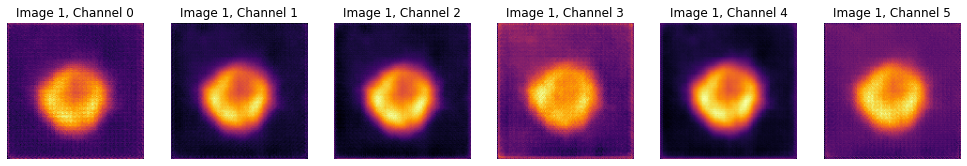

In [54]:

plt.figure(figsize=(20, 20))

for j in range(X_fakeB.shape[-1]):
    img = X_fakeB[0,:, :, j]
    plt.subplot(1, 7, 0 * 7 + j + 1)
    plt.imshow(img, cmap='inferno')
    plt.title(f'Image {1}, Channel {j}')
    plt.axis('off')
    print(img.min(), img.max())

plt.show()
